# Library

In [1]:
import math
import random
import squigglepy as sq
from squigglepy import bayes
from squigglepy.numbers import K, M, B, T

import numpy as np
import matplotlib.pyplot as plt

from copy import deepcopy
from scipy import stats
from pprint import pprint
from collections import Counter
%matplotlib inline
print('Loaded 1')


exec(open('utils.py').read())
print('Loaded 2')

Loaded 1
Loaded 2


In [2]:
# Global variables - probably don't want to change these but you could.
RUNS = 100*K                                      # Number of runs to do (default 100*K)
CURRENT_YEAR = 2022                               # What year to start the run on? (default: 2022)
MAX_YEAR = 2222                                   # What year to end the run on? (default: 2100)


years = range(CURRENT_YEAR, MAX_YEAR)
print('Loaded')


Loaded


# Model

### TAI Scenarios

In [3]:
# Conditoinal on making TAI, will it be agentic?
p_make_agent_tai = 0.9

# Conditional on making agentic TAI, will it be aligned by default?
p_tai_aligned_by_default = 0.1

# Conditional on making agentic TAI that is not aligned by default, will we solve the alignment problem?
# Varies by year, whether this is the first attempt, and whether there is a great power war
def p_alignment_solved(war, year, first_attempt=True, verbose=False):
    if first_attempt:
        p = min(0.05 + 1.15 * (year/45), 0.75)
    else:
        p = min(0.05 + 1.5 * (year/45), 0.85)
    if war:
        p = p * 0.7
    if verbose == 2:
        print('* alignment diagnostic - war: {} year: {} first attempt: {} -> p {})'.format(war, year, first_attempt, p))
    return p
# TODO: Convert to logistic curves

# Conditional on solving the alignment problem, what is the chance we also solve the subtle misalignment problem?
p_subtle_alignment_solved = 0.85

# Conditional on alignment by default, what is the chance we also solve the subtle misalignment problem?
p_subtle_alignment_solved_if_aligned_by_default = 0.65

# Conditional on having agentic TAI, will it be intentionally misused to create a singleton?
def p_tai_intentional_misuse(war):
    return 0.3 if war else 0.05

# If TAI is fully misaligned what is the chance we can successfully detect and avert this?
p_full_tai_misalignment_averted = 0.15

# If TAI is fully misaligned but successfully averted, what is the probability there will be a catasrophe (10%+ death)?
p_tai_misalignment_averting_is_catastrophic = 0.4

# If TAI is fully misaligned and we successfully avert it, what is the chance we give up on TAI?
p_full_tai_misalignment_averted_means_abandoned_tai = 0.7

# If TAI is fully misaligned, what is the chance it results in extinction versus a singleton?
p_tai_xrisk_is_extinction = 0.4

# If there is a fully misaligned TAI singleton, what is the chance it results in a non-extinction catastrophe (10%+ death)?
p_tai_singleton_is_catastrophic = 0.8


exec(open('modules/tai.py').read())
print('Loaded TAI scenarios module')


Loaded TAI scenarios module


### Nuclear Scenarios Module

In [4]:
def p_russia_uses_nuke(peace, year):
    peace = 10 if peace else 1
    year = year + CURRENT_YEAR
    if year == 2022 or year == 2023:
        return 0.05 / 2
    else:
        return 0.001 / peace

    
p_nk_uses_nuke = 0.001


def p_china_invades_taiwan(peace, year):
    peace = 10 if peace else 1
    year = year + CURRENT_YEAR
    if year == 2022:
        return 0
    elif year == 2023:
        return 0.03
    elif year == 2024:
        return 0.145 # makes cumulative probability by EOY 2025 = 0.17 (0.03 + 0.145*(1-0.03) = 0.17)
    elif year < 2030:
        return 0.096 # makes cumulative probability by EOY 2029 = 0.5
                     # 0.17 + (1-0.17)*X + (1-0.17)(1-X)*X + (1-0.17)(1-X)^2*X + (1-0.17)(1-X)^3*X + (1-0.17)(1-X)^4*X = 0.5
    elif year < 2035:
        return 0.097 # makes cumulative probability by EOY 2034 = 0.7
                     # 0.5 + (1-0.5)*X + (1-0.5)(1-X)*X + (1-0.5)(1-X)^2*X + (1-0.5)(1-X)^3*X + (1-0.5)(1-X)^4*X = 0.7
    else:
        return 0.005 / peace


def p_china_uses_nuke(peace, year):
    return p_china_invades_taiwan(peace, year) * 0.01

    
def p_other_uses_nuke(peace):
    peace = 10 if peace else 1
    return 0.0002 / peace


# What is the chance in a given year there will be a "nuclear accident"?
def p_nuclear_accident(war, year):
    p = 0.05 if war else 0.02
    p = p * (0.998 ** year)
    return p


# Conditional on a nuclear accident, what is the chance it escalates into an "exchange"?
def p_nuclear_accident_becomes_exchange(war):
    return 0.2 if war else 0.05


# Conditional on a nuclear exchange, what is the chance it escalates into a catastrophe (10%+ dead)?
def p_catastrophe_from_nuclear_exchange(war):
    p_exchange_becomes_all_out_war = 0.6 if war else 0.3
    p_nuclear_winter_happens = 0.3
    alternative_foods_or_other_save = 0.05
    return (p_exchange_becomes_all_out_war *
            (p_nuclear_winter_happens + (1 - p_nuclear_winter_happens) * 0.1) *
            (1 - alternative_foods_or_other_save))
    
    
# Conditional on a nuclear exchange catastrophe, what is the chance it becomes an xrisk?
p_xrisk_from_nuclear_catastrophe = 0.05 # https://forum.effectivealtruism.org/posts/GsjmufaebreiaivF7/what-is-the-likelihood-that-civilizational-collapse-would


# Conditional on a great power war, what is the chance it goes intentionally nuclear in any given year?
def p_nuclear_exchange_given_war(first_year_of_war):
    return 0.1 if first_year_of_war else 0.02


exec(open('modules/nuclear.py').read())
print('Loaded nuclear scenarios module')


Loaded nuclear scenarios module


### Great Power War Scenarios Module

In [5]:
def p_great_power_war_us_russia_without_nuke_first(peace, year):
    peace = 20 if peace else 1
    year = year + CURRENT_YEAR
    if year == 2022 or year == 2023:
        return (0.02 / 2) / peace
    else:
        return 0.003 / peace

    
def p_great_power_war_us_china(peace, year):
    peace = 20 if peace else 1
    p_invade_taiwan = p_china_invades_taiwan(peace, year)
    p_us_responds = 0.6
    return p_invade_taiwan * p_us_responds

    
def p_great_power_war_other(peace, year):
    peace = 5 if peace else 1
    year = year + CURRENT_YEAR
    if year > 2040:
        return 0.005 / peace
    else:
        return 0.001 / peace


# Conditional on a great power war starting, how long will it last?
war_length = sq.lognorm(2, 50) # 90% CI

# After a war ends, how long will there be a peace?
peace_length = sq.lognorm(10, 100)


exec(open('modules/great_power_war.py').read())
print('Loaded great power war scenarios module')


Loaded great power war scenarios module


### Bio scenarios module

In [6]:
# Conditional on a great power war, what is the annual chance it intentionally results in a bioweapon?
p_biowar_given_war = 1/800

# What is the annual chance of a non-state actor creating an intentional biorisk that causes 1%+ death?
p_nonstate_bio = 1/1200

# What is the chance that if 1%+ die from natural bio, 10%+ will die from natural bio?
p_natural_bio_is_catastrophe = 1 / (10 ** 0.5) # https://www.liebertpub.com/doi/pdfplus/10.1089/hs.2017.0028

# What is the chance that if 1%+ die from engineered bio, 10%+ will die from engineered bio?
p_engineered_bio_is_catastrophe = 1 / (10 ** 0.5) # https://www.liebertpub.com/doi/pdfplus/10.1089/hs.2017.0028

p_covid_spanish_flu_like_becomes_1pct_death = 1 / (10 ** 0.5) # https://www.economist.com/graphic-detail/coronavirus-excess-deaths-estimates suggests COVID killed 0.2%... https://www.liebertpub.com/doi/pdfplus/10.1089/hs.2017.0028 suggests 1% is 2x less likely than 0.2%
p_covid_lab_leak = 0.3
p_extinction_given_90_pct_death = 0.03 # per Luisa https://forum.effectivealtruism.org/posts/GsjmufaebreiaivF7/what-is-the-likelihood-that-civilizational-collapse-would
p_accidental_catastrophe_causes_90_pct_death = (1 / (10 ** 0.5)) ** 2 # https://www.liebertpub.com/doi/pdfplus/10.1089/hs.2017.0028
p_intentional_catastrophe_causes_90_pct_death = (1 / (10 ** 0.5)) ** 2 # https://www.liebertpub.com/doi/pdfplus/10.1089/hs.2017.0028

# If a lab leak occurs, how likely is it that the leaked pandemic will be engineered vs. natural?
ratio_engineered_vs_natural_lab_leak = 0.8

# What is the chance of an natural biorisk/pandemic causing 1%+ population death?
def p_natural_bio(year):
    base_rate_from_covid_and_spanish_flu = 1/250
    increase_from_globalization = 1.1
    decreate_in_rate_per_year_from_improvements = 0.99 ** year
    return ((base_rate_from_covid_and_spanish_flu * 0.5 +
             base_rate_from_covid_and_spanish_flu * (1 - p_covid_lab_leak) * 0.5) *
            increase_from_globalization *
            p_covid_spanish_flu_like_becomes_1pct_death *
            decreate_in_rate_per_year_from_improvements)
    
    
# What is the chance of an accidental biorisk (e.g., lab leak) causing 1%+ population death?
def p_accidental_bio(war):
    base_rate_from_covid = 0.01 * p_covid_lab_leak
    increase_factor_due_to_increasing_labs = 1.3
    increase_factor_due_to_great_power_war = 2
    p = (base_rate_from_covid *
         p_covid_spanish_flu_like_becomes_1pct_death *
         increase_factor_due_to_increasing_labs)
    return p * increase_factor_due_to_great_power_war if war else p
    

# Conditional on a accidental biorisk (1% death), what is the chance it becomes a xrisk?
def p_xrisk_from_accidental_bio_given_catastrophe(year):
    return p_accidental_catastrophe_causes_90_pct_death * p_extinction_given_90_pct_death


# Conditional on a bioweapon, what is the chance it becomes a xrisk?
def p_xrisk_from_engineered_bio_given_catastrophe(year):
    return p_intentional_catastrophe_causes_90_pct_death * p_extinction_given_90_pct_death


exec(open('modules/bio.py').read())
print('Loaded bio scenarios module')


Loaded bio scenarios module


### Nanotech scenarios module

In [7]:
# What is the chance in a given year that nanotech will be developed?
def p_nanotech_possible(year):
    return 0.0001 / (0.956 ** year) # TODO: This goes over 1


# Conditional on developing nanotech, what is the chance nanotech results in an xrisk?
p_nanotech_is_xrisk = 0.1 * 0.05


exec(open('modules/nano.py').read())
print('Loaded nano scenarios module')


Loaded nano scenarios module


### Supervolcano scenarios module (all other natural risks <0.01%)

In [8]:
p_supervolcano_catastrophe = 1 / (500*K)  # https://www.openphilanthropy.org/research/large-volcanic-eruptions/ VEI >= 9 (geometric mean of 30K and 30M)

p_supervolcano_extinction_given_catastrophe = 0.05


exec(open('modules/supervolcano.py').read())
print('Loaded supervolcano module')


Loaded supervolcano module


### Unknown unknown scenarios module

In [9]:
# What is the chance in any given year that an unknown unknown xrisk occurs?
def p_unknown_unknown_xrisk(year):
    return (1 / (100*K)) / (0.99 ** year) # TODO: This goes over 1


p_extinction_from_double_catastrophe = 0.1
extinction_from_double_catastrophe_range = 10
    
    
exec(open('modules/unknown_unknown.py').read())
print('Loaded unknown unknown scenarios module')


Loaded unknown unknown scenarios module


### AI Timeline variables

In [10]:
## AI TIMELINE VARIABLES

def sample_tai_log_flop_needs(brain, efficiency, transformative_vs_human, horizon_length, scaling_exponent,
                              flops_per_param_per_sec, params=None, ref_params=11.2, ref_params_samples=12,
                              bayes_update=None, debug=False):
    # Debug = 1 for just printing parameters
    # Debug = 2 for just printing the equation
    # Debug = True or debug = 3 for printing both
    
    if bayes_update is None:
        bayes_update = lambda x: x
    
    brain_ = ~brain
    eff_ = ~efficiency
    tvh_ = ~transformative_vs_human
    h_ = ~horizon_length
    e_ = ~scaling_exponent
    fpp_ = ~flops_per_param_per_sec
    
    if debug is True or debug == 1 or debug == 2 or debug == 3:
        print('Anchor debug:')
        
    if debug is True or debug == 1 or debug == 3:
        print('-- Assume human brain in inference takes {} log FLOP (i.e., 10^{} FLOP)'.format(round(brain_, 1),
                                                                                               round(brain_, 1)))
        print('-- Add {} log FLOP for efficiency'.format(round(eff_, 1)))
        print('-- Assume a transformative model takes {} log FLOP compared to human'.format(round(tvh_, 1)))
        print('-- Assume a horizon length of {}'.format(round(h_, 1)))
        print('-- Assume a scaling exponent of {}'.format(round(e_, 3)))
        print('-- Assume FLOPs per param per sec of {}'.format(round(fpp_, 1)))
    
    if params is None:
        params_ = brain_ + eff_ - fpp_        
    else:
        params_ = ~params
    
    out = brain_ + eff_ + tvh_ + h_ + ref_params_samples - e_ * ref_params + e_ * params_
    
    if debug is True or debug == 2 or debug == 3:
        if params is None:
            print(f"-- {round(out, 1)} = {round(brain_, 1)} + {round(eff_, 1)} + {round(tvh_, 1)} + {round(h_, 1)} + {ref_params_samples} - {round(e_, 3)} * {ref_params} + {round(e_, 3)} * ({round(brain_, 1)} + {round(eff_, 1)} - {round(fpp_, 1)})")
        else:
            print(f"-- {round(out, 1)} = {round(brain_, 1)} + {round(eff_, 1)} + {round(tvh_, 1)} + {round(h_, 1)} + {ref_params_samples} - {round(e_, 3)} * {ref_params} + {round(e_, 3)} * {round(params_, 2)}")
    
    out = bayes_update(out)
    if debug is True or debug == 2 or debug == 3:
        print('-- {} after Bayes update'.format(round(out, 1)))
    if debug is True or debug == 1 or debug == 2 or debug == 3:
        print('-')

    return out


def wildeford_bayes_update_against_low_flop(f):
    f = f + ~sq.norm(1,3) if f < 27 and sq.event_occurs(p=0.1) else f
    f = f + ~sq.norm(1,3) if f < 26 and sq.event_occurs(p=0.2) else f
    f = f + ~sq.norm(1,3) if f < 25 and sq.event_occurs(p=0.6) else f
    f = f + ~sq.norm(1,3) if f < 24 and sq.event_occurs(p=0.8) else f
    return f


def wildeford_meta_anchor(efficiency, debug=False):
    horizon_length = sq.mixture([[0.4, sq.const(0)],
                                 [0.2, sq.norm(0,3)],
                                 [0.25, sq.lognorm(3,7)],
                                 [0.15, sq.norm(7,11)]],
                                lclip=0)
    
    return sample_tai_log_flop_needs(brain=sq.lognorm(11,19.5),
                                     efficiency=efficiency,
                                     transformative_vs_human=sq.norm(-2,1),
                                     horizon_length=horizon_length,
                                     scaling_exponent=sq.norm(0.5,1.5),
                                     flops_per_param_per_sec=sq.norm(1,2),
                                     bayes_update=wildeford_bayes_update_against_low_flop,
                                     debug=debug)


def max_gdp_frac(war):
    small_project = sq.lognorm(1 / (250*K), 1 / (3*K))
    modern_megaproject = sq.lognorm(1/K, 1/600)
    old_form_megaproject = sq.lognorm(1/500, 1/150)
    gigaproject = sq.lognorm(1/150, 1/50)
    
    r_ = random.random()
    if (not war and r_ < 0.3) or (war and r_ < 0.05):
        gdp_frac = small_project
        percent_spent_on_compute = sq.lognorm(0.2,0.6, lclip=0.1, rclip=0.9)
    elif (not war and r_ < 0.9) or (war and r_ < 0.4):
        gdp_frac = modern_megaproject
        percent_spent_on_compute = sq.lognorm(0.4,0.7, lclip=0.1, rclip=0.9)
    elif not war or (war and r_ < 0.9):
        gdp_frac = old_form_megaproject
        percent_spent_on_compute = sq.lognorm(0.5,0.9, lclip=0.1, rclip=0.9)
    else:
        gdp_frac = gigaproject
        percent_spent_on_compute = sq.lognorm(0.6,0.9, lclip=0.1, rclip=0.9)
        
    return gdp_frac * percent_spent_on_compute


initial_gdp = 21.3*T

initial_flops_per_dollar = sq.const(18)

tai_flop_size = wildeford_meta_anchor

flops_halving_rate = sq.lognorm(2, 5)

initial_pay = sq.mixture([[0.8, sq.const(7.1)],
                          [0.2, sq.lognorm(7.1,9, lclip=7.1)]])

max_flops_per_dollar = sq.const(24)

gdp_growth = sq.lognorm(1.015, 1.035) #NEW

spend_doubling_time = sq.mixture([[0.8, sq.lognorm(3,6)],
                                  [0.2, sq.lognorm(1,2, lclip=1)]])
# TODO: Willingness to spend connected to commercialization

initial_chance_of_nonscaling_issue = 0.95
final_chance_of_nonscaling_issue = 0.3 #NEW
nonscaling_issue_bottom_year = 2050
nonscaling_delay = sq.mixture([[0.7, sq.lognorm(2,10)],
                               [0.3, sq.lognorm(5,40)]]) #NEW

algo_doubling_rate_max = sq.norm(1,3) # NEW
algo_doubling_rate_min = sq.norm(1,2) # NEW

efficiency = sq.mixture([[0.1, sq.const(0)],
                          [0.9, sq.lognorm(1,4)]])

use_efficiency_based_algo_reduction = True
efficiency_based_additional_reduction = sq.mixture([[0.4, sq.const(0)],
                                                    [0.6, sq.norm(0,2)]]) # NEW

p_willingness_ramp = 0

willingness_spend_horizon = sq.const(1)

tai_china_war_delay_yrs = sq.norm(2,6)
tai_china_war_delay_end_year = 2040

tai_catastrophe_delay_yrs = sq.lognorm(4,20)

# These equations define how variables change over time or in relationship to other variables.
def gdp(initial_gdp, gdp_growth, year):
    return initial_gdp * (gdp_growth ** year)


def willingness_to_pay(initial_gdp, gdp_growth, initial_pay, spend_doubling_time, max_gdp_frac, year):
    gdp_ = gdp(initial_gdp=initial_gdp, gdp_growth=gdp_growth, year=year)
    x = (np.log(2) / spend_doubling_time) * year
    if x < 650:
        y = math.log10(initial_pay) + math.log10(math.exp(x)) - math.log10(1 + initial_pay / (gdp_ * max_gdp_frac) * math.exp(x))
        if y > 300:
            y = int(y) # Handle overflow errors
        return 10 ** y
    else: # Handle math.exp and math.log10 overflow errors
        return 10 ** int(math.log10(initial_pay) + (year/spend_doubling_time)/3.3)
    

def algo_halving_fn(min_speed, max_speed, tai_flop_size):
    if max_speed < min_speed:
        max_speed = min_speed
    if min_speed > max_speed:
        min_speed = max_speed
    return min(max(max_speed - (round((tai_flop_size - 29) / 2) / 2), min_speed), max_speed)


def flops_needed(initial_flops, possible_reduction, doubling_rate, year):
    x = (np.log(2) / doubling_rate) * year
    if x < 650:
        y = (math.log10(initial_flops) - max(math.log10(math.exp(x)) - math.log10(1 + (1/possible_reduction) * math.exp(x)), 0))
        if y > 300:
            y = int(y) # Handle overflow errors        
        return 10 ** y
    else: # Handle math.exp and math.log10 overflow errors
        return 10 ** int(math.log10(initial_flops) - (1/possible_reduction))

    
def flops_per_dollar(initial_flops_per_dollar, max_flops_per_dollar, halving_rate, year):
    x = (np.log(2) / halving_rate) * year
    if x < 650:
        y = (math.log10(initial_flops_per_dollar) + math.log10(math.exp(x)) - math.log10(1 + initial_flops_per_dollar / max_flops_per_dollar * math.exp(x)))
        if y > 300:
            y = int(y) # Handle overflow errors                
        return 10 ** y
    else: # Handle math.exp and math.log10 overflow errors
        return 10 ** int(math.log10(initial_flops_per_dollar) + (year/halving_rate)/3.3)

    
def cost_of_tai(initial_flops, possible_reduction, algo_doubling_rate, initial_flops_per_dollar, max_flops_per_dollar,
                flops_halving_rate, year):
    return (flops_needed(initial_flops, possible_reduction, algo_doubling_rate, year) /
            flops_per_dollar(initial_flops_per_dollar, max_flops_per_dollar, flops_halving_rate, year))


def possible_algo_reduction_fn(min_reduction, max_reduction, tai_flop_size):
    if max_reduction < min_reduction:
        max_reduction = min_reduction
    if min_reduction > max_reduction:
        min_reduction = max_reduction
    return min(max(min_reduction + round((tai_flop_size - 32) / 4), min_reduction), max_reduction)


# NEW
def p_nonscaling_delay(initial_p, final_p, year, max_year):
    return generalized_logistic_curve(x=year - CURRENT_YEAR,
                                      slope=0.3,
                                      shift=3 * (max_year - CURRENT_YEAR),
                                      push=1,
                                      maximum=final_p,
                                      minimum=initial_p)


print('Loaded')


Loaded


### Overall module structure

In [11]:
exec(open('modules/define_event.py').read())
print('Model loaded')


Model loaded


In [12]:
sq.get_percentiles(max_gdp_frac(war=True) @ 1000)

{1: 0.003640050045021573,
 5: 0.004529698813459676,
 10: 0.0051906145763550016,
 20: 0.006034488208661356,
 30: 0.006810674074364763,
 40: 0.007511377442659281,
 50: 0.00814889695055243,
 60: 0.008860596372143486,
 70: 0.009849869515717162,
 80: 0.011060894786178367,
 90: 0.012840366553188674,
 95: 0.014523689925103112,
 99: 0.019078704498979412}

In [13]:
sq.get_percentiles(max_gdp_frac(war=False) @ 1000)

{1: 4.5580067545990946e-07,
 5: 1.1460092998983404e-06,
 10: 1.959113580644733e-06,
 20: 3.7817306073881777e-06,
 30: 5.5657783755455775e-06,
 40: 8.618990596345995e-06,
 50: 1.1867682813481195e-05,
 60: 1.61687613086353e-05,
 70: 2.3536824063230756e-05,
 80: 3.75067710835211e-05,
 90: 7.680162294251189e-05,
 95: 0.00012597422764129733,
 99: 0.00028207827257383926}

In [14]:
sq.get_percentiles([int(round(x)) for x in tai_china_war_delay_yrs @ 1000])

{1: 1.0,
 5: 2.0,
 10: 2.0,
 20: 3.0,
 30: 3.0,
 40: 4.0,
 50: 4.0,
 60: 4.0,
 70: 5.0,
 80: 5.0,
 90: 6.0,
 95: 6.0,
 99: 7.0}

In [15]:
sq.get_percentiles([int(round(x)) for x in tai_catastrophe_delay_yrs @ 1000])

{1: 3.0,
 5: 4.0,
 10: 5.0,
 20: 6.0,
 30: 7.0,
 40: 8.0,
 50: 9.0,
 60: 10.0,
 70: 12.0,
 80: 14.0,
 90: 17.0,
 95: 19.0,
 99: 30.0}

Anchor debug:
-- Assume human brain in inference takes 10.3 log FLOP (i.e., 10^10.3 FLOP)
-- Add 0 log FLOP for efficiency
-- Assume a transformative model takes -1.2 log FLOP compared to human
-- Assume a horizon length of 5.1
-- Assume a scaling exponent of 0.979
-- Assume FLOPs per param per sec of 0.8
-- 24.6 = 10.3 + 0 + -1.2 + 5.1 + 12 - 0.979 * 11.2 + 0.979 * (10.3 + 0 - 0.8)
-- 24.6 after Bayes update
-
### TAI TIMELINE VARIABLES ###
(Note: `log` refers to `log10`)
It takes 24.6 log FLOPs (~4 septillion) for transformative capabilities.
Every 2.6 years algorithms get 2x better, with 0 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 3.1 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 7.1 log 2022$USD (~13 million) and this increases by 3.1x per year to a max of 0.00057% of GDP. GDP grows at a rate of 1.016x per year.
If a non-scaling delay happens, it will take an 

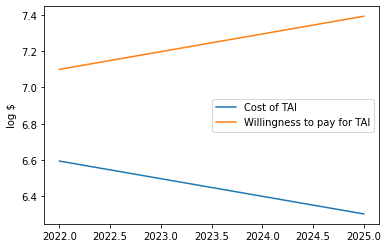

2025: ...XRISK from fully unaligned TAI (singleton) :(
...Singleton is catastrophic
-
-
{'collectors': {2022: {'averted_misalignment': False,
                       'catastrophe': [],
                       'category': 'boring',
                       'china_nuke_first': False,
                       'double_catastrophe_xrisk': None,
                       'engineered_pathogen': False,
                       'final_year': None,
                       'nano': False,
                       'natural_pathogen': False,
                       'nuclear_weapon_used': False,
                       'peace_until': None,
                       'recent_catastrophe_year': None,
                       'russia_nuke_first': False,
                       'tai': False,
                       'tai_type': None,
                       'tai_year': None,
                       'terminate': False,
                       'war': False,
                       'war_belligerents': None,
                       'war_

                       'china_nuke_first': False,
                       'double_catastrophe_xrisk': None,
                       'engineered_pathogen': False,
                       'final_year': 2025,
                       'nano': False,
                       'natural_pathogen': False,
                       'nuclear_weapon_used': False,
                       'peace_until': None,
                       'recent_catastrophe_year': None,
                       'russia_nuke_first': False,
                       'tai': True,
                       'tai_type': 'agent',
                       'tai_year': 2025,
                       'terminate': True,
                       'war': False,
                       'war_belligerents': None,
                       'war_end_year': None,
                       'war_start_year': None,
                       'wars': []},
                2209: {'averted_misalignment': False,
                       'catastrophe': ['xrisk_full_unaligned_tai_singleton

In [16]:
pprint(define_event(verbosity=3))

--- /!\ TAI CREATED in 2059


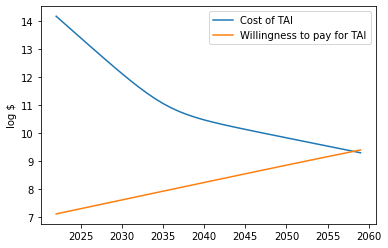

2059: ...Achieved aligned TAI (aligned via work, first attempt), happy future! :D
-
-


In [17]:
define_event(verbosity=1); None

-
-
############
## RUN 1 ##
############
Anchor debug:
-- Assume human brain in inference takes 14.0 log FLOP (i.e., 10^14.0 FLOP)
-- Add 1.8 log FLOP for efficiency
-- Assume a transformative model takes -1.5 log FLOP compared to human
-- Assume a horizon length of 0
-- Assume a scaling exponent of 1.227
-- Assume FLOPs per param per sec of 1.7
-- 29.9 = 14.0 + 1.8 + -1.5 + 0 + 12 - 1.227 * 11.2 + 1.227 * (14.0 + 1.8 - 1.7)
-- 29.9 after Bayes update
-
### TAI TIMELINE VARIABLES ###
(Note: `log` refers to `log10`)
It takes 29.9 log FLOPs (~716 octillion) for transformative capabilities.
Every 2.3 years algorithms get 2x better, with 1.8 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 2.0 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 7.1 log 2022$USD (~13 million) and this increases by 4.3x per year to a max of 0.00071% of GDP. GDP grows at a rate of 1.024x per year.
I

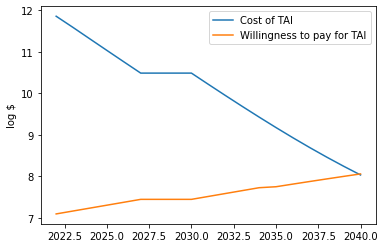

2040: ...XRISK from fully unaligned TAI (extinction) :(
-
-
-
-
############
## RUN 2 ##
############
Anchor debug:
-- Assume human brain in inference takes 13.4 log FLOP (i.e., 10^13.4 FLOP)
-- Add 2.4 log FLOP for efficiency
-- Assume a transformative model takes -1.2 log FLOP compared to human
-- Assume a horizon length of 0
-- Assume a scaling exponent of 1.05
-- Assume FLOPs per param per sec of 1.2
-- 30.0 = 13.4 + 2.4 + -1.2 + 0 + 12 - 1.05 * 11.2 + 1.05 * (13.4 + 2.4 - 1.2)
-- 30.0 after Bayes update
-
### TAI TIMELINE VARIABLES ###
(Note: `log` refers to `log10`)
It takes 30.0 log FLOPs (~896 octillion) for transformative capabilities.
Every 1.5 years algorithms get 2x better, with 2.4 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 3.6 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 7.1 log 2022$USD (~13 million) and this increases by 5.4x per year to a max of 0

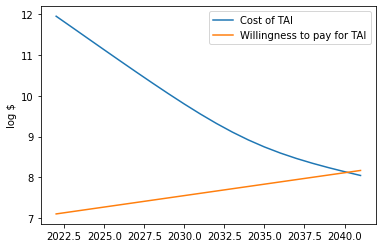

2041: ...XRISK from fully unaligned TAI (extinction) :(
-
-
-
-
############
## RUN 3 ##
############
Anchor debug:
-- Assume human brain in inference takes 13.6 log FLOP (i.e., 10^13.6 FLOP)
-- Add 3.0 log FLOP for efficiency
-- Assume a transformative model takes -0.6 log FLOP compared to human
-- Assume a horizon length of 0
-- Assume a scaling exponent of 0.864
-- Assume FLOPs per param per sec of 1.6
-- 31.3 = 13.6 + 3.0 + -0.6 + 0 + 12 - 0.864 * 11.2 + 0.864 * (13.6 + 3.0 - 1.6)
-- 31.3 after Bayes update
-
### TAI TIMELINE VARIABLES ###
(Note: `log` refers to `log10`)
It takes 31.3 log FLOPs (~19 nonillion) for transformative capabilities.
Every 1.5 years algorithms get 2x better, with 3.0 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 3.8 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 7.1 log 2022$USD (~13 million) and this increases by 5.2x per year to a max of

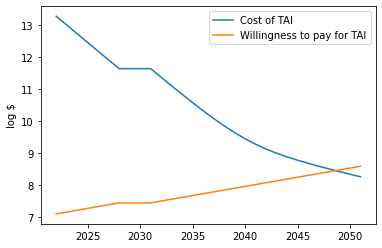

2051: ...Achieved aligned TAI (aligned via work, first attempt), happy future! :D
-
-
-
-
############
## RUN 4 ##
############
Anchor debug:
-- Assume human brain in inference takes 14.0 log FLOP (i.e., 10^14.0 FLOP)
-- Add 1.2 log FLOP for efficiency
-- Assume a transformative model takes 1.3 log FLOP compared to human
-- Assume a horizon length of 9.1
-- Assume a scaling exponent of 0.935
-- Assume FLOPs per param per sec of 1.4
-- 40.0 = 14.0 + 1.2 + 1.3 + 9.1 + 12 - 0.935 * 11.2 + 0.935 * (14.0 + 1.2 - 1.4)
-- 40.0 after Bayes update
-
### TAI TIMELINE VARIABLES ###
(Note: `log` refers to `log10`)
It takes 40.0 log FLOPs (~11 million decillion) for transformative capabilities.
Every 2.2 years algorithms get 2x better, with 1.8 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 2.4 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 7.1 log 2022$USD (~13 million) and this in

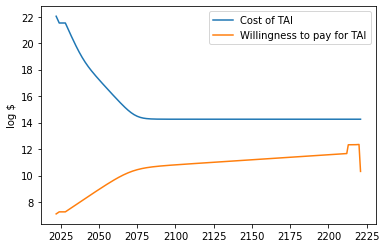

-
-
-
-
############
## RUN 5 ##
############
Anchor debug:
-- Assume human brain in inference takes 18.7 log FLOP (i.e., 10^18.7 FLOP)
-- Add 1.7 log FLOP for efficiency
-- Assume a transformative model takes 0.5 log FLOP compared to human
-- Assume a horizon length of 0
-- Assume a scaling exponent of 0.936
-- Assume FLOPs per param per sec of 1.6
-- 39.9 = 18.7 + 1.7 + 0.5 + 0 + 12 - 0.936 * 11.2 + 0.936 * (18.7 + 1.7 - 1.6)
-- 39.9 after Bayes update
-
### TAI TIMELINE VARIABLES ###
(Note: `log` refers to `log10`)
It takes 39.9 log FLOPs (~7 million decillion) for transformative capabilities.
Every 1.3 years algorithms get 2x better, with 2.9 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 4.0 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 7.1 log 2022$USD (~13 million) and this increases by 1.6x per year to a max of 3e-05% of GDP. GDP grows at a rate of 1.027x per y

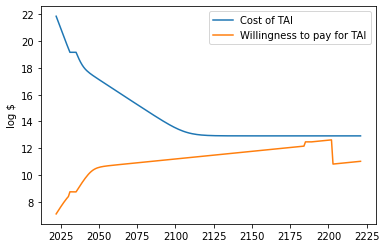

-
-
-
-
############
## RUN 6 ##
############
Anchor debug:
-- Assume human brain in inference takes 12.0 log FLOP (i.e., 10^12.0 FLOP)
-- Add 2.7 log FLOP for efficiency
-- Assume a transformative model takes -1.5 log FLOP compared to human
-- Assume a horizon length of 0
-- Assume a scaling exponent of 0.821
-- Assume FLOPs per param per sec of 1.4
-- 27.1 = 12.0 + 2.7 + -1.5 + 0 + 12 - 0.821 * 11.2 + 0.821 * (12.0 + 2.7 - 1.4)
-- 27.1 after Bayes update
-
### TAI TIMELINE VARIABLES ###
(Note: `log` refers to `log10`)
It takes 27.1 log FLOPs (~1 octillion) for transformative capabilities.
Every 2.7 years algorithms get 2x better, with 2.6 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 2.1 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 7.1 log 2022$USD (~13 million) and this increases by 5.0x per year to a max of 0.00096% of GDP. GDP grows at a rate of 1.025x per year.

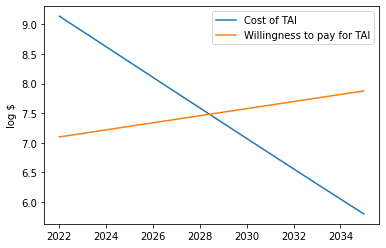

2035: ...Misaligned TAI happened, it was averted with catastrophe, and we abandon TAI
2067: WAR!!! (US vs. Russia)
2067: ...catastrophe from nukes (war)
2088: ...catastrophe from nukes (war)
2094: War ends :)
...Boring future
-
-
-
-
############
## RUN 7 ##
############
Anchor debug:
-- Assume human brain in inference takes 14.1 log FLOP (i.e., 10^14.1 FLOP)
-- Add 2.1 log FLOP for efficiency
-- Assume a transformative model takes -0.8 log FLOP compared to human
-- Assume a horizon length of 0
-- Assume a scaling exponent of 0.905
-- Assume FLOPs per param per sec of 1.4
-- 30.6 = 14.1 + 2.1 + -0.8 + 0 + 12 - 0.905 * 11.2 + 0.905 * (14.1 + 2.1 - 1.4)
-- 30.6 after Bayes update
-
### TAI TIMELINE VARIABLES ###
(Note: `log` refers to `log10`)
It takes 30.6 log FLOPs (~4 nonillion) for transformative capabilities.
Every 2.3 years algorithms get 2x better, with 2.9 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 3.8 years they get 2x c

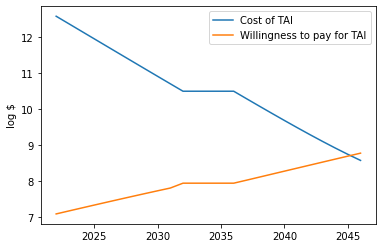

2046: ...XRISK from fully unaligned TAI (singleton) :(
-
-
-
-
############
## RUN 8 ##
############
Anchor debug:
-- Assume human brain in inference takes 16.3 log FLOP (i.e., 10^16.3 FLOP)
-- Add 2.1 log FLOP for efficiency
-- Assume a transformative model takes -0.5 log FLOP compared to human
-- Assume a horizon length of 1.3
-- Assume a scaling exponent of 1.199
-- Assume FLOPs per param per sec of 1.5
-- 38.1 = 16.3 + 2.1 + -0.5 + 1.3 + 12 - 1.199 * 11.2 + 1.199 * (16.3 + 2.1 - 1.5)
-- 38.1 after Bayes update
-
### TAI TIMELINE VARIABLES ###
(Note: `log` refers to `log10`)
It takes 38.1 log FLOPs (~128 thousand decillion) for transformative capabilities.
Every 1.3 years algorithms get 2x better, with 2.1 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 3.4 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 7.1 log 2022$USD (~13 million) and this increases by 4.8x per yea

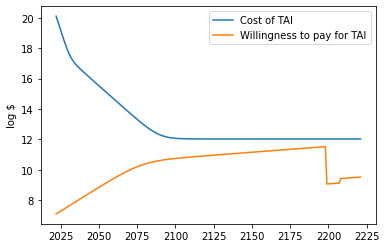

-
-
-
-
############
## RUN 9 ##
############
Anchor debug:
-- Assume human brain in inference takes 20.2 log FLOP (i.e., 10^20.2 FLOP)
-- Add 0 log FLOP for efficiency
-- Assume a transformative model takes -0.5 log FLOP compared to human
-- Assume a horizon length of 0
-- Assume a scaling exponent of 0.887
-- Assume FLOPs per param per sec of 1.3
-- 38.4 = 20.2 + 0 + -0.5 + 0 + 12 - 0.887 * 11.2 + 0.887 * (20.2 + 0 - 1.3)
-- 38.4 after Bayes update
-
### TAI TIMELINE VARIABLES ###
(Note: `log` refers to `log10`)
It takes 38.4 log FLOPs (~259 thousand decillion) for transformative capabilities.
Every 1.4 years algorithms get 2x better, with 1.2 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 4.5 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 7.1 log 2022$USD (~13 million) and this increases by 1.8x per year to a max of 5e-05% of GDP. GDP grows at a rate of 1.033x per ye

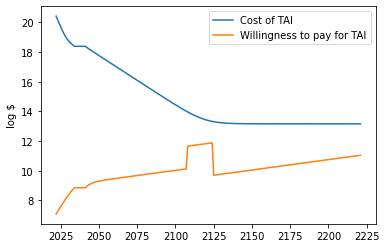

-
-
-
-
############
## RUN 10 ##
############
Anchor debug:
-- Assume human brain in inference takes 13.8 log FLOP (i.e., 10^13.8 FLOP)
-- Add 2.5 log FLOP for efficiency
-- Assume a transformative model takes -1.9 log FLOP compared to human
-- Assume a horizon length of 0
-- Assume a scaling exponent of 1.307
-- Assume FLOPs per param per sec of 1.6
-- 31.0 = 13.8 + 2.5 + -1.9 + 0 + 12 - 1.307 * 11.2 + 1.307 * (13.8 + 2.5 - 1.6)
-- 31.0 after Bayes update
-
### TAI TIMELINE VARIABLES ###
(Note: `log` refers to `log10`)
It takes 31.0 log FLOPs (~11 nonillion) for transformative capabilities.
Every 1.2 years algorithms get 2x better, with 3.5 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 2.2 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 8.3 log 2022$USD (~186 million) and this increases by 1.3x per year to a max of 0.00066% of GDP. GDP grows at a rate of 1.024x per ye

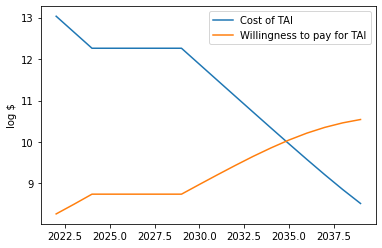

2039: ...XRISK from fully unaligned TAI (extinction) :(
-
-
-
-
############
## RUN 11 ##
############
Anchor debug:
-- Assume human brain in inference takes 14.1 log FLOP (i.e., 10^14.1 FLOP)
-- Add 1.6 log FLOP for efficiency
-- Assume a transformative model takes -0.3 log FLOP compared to human
-- Assume a horizon length of 0
-- Assume a scaling exponent of 1.088
-- Assume FLOPs per param per sec of 1.8
-- 30.4 = 14.1 + 1.6 + -0.3 + 0 + 12 - 1.088 * 11.2 + 1.088 * (14.1 + 1.6 - 1.8)
-- 30.4 after Bayes update
-
### TAI TIMELINE VARIABLES ###
(Note: `log` refers to `log10`)
It takes 30.4 log FLOPs (~2 nonillion) for transformative capabilities.
Every 1.2 years algorithms get 2x better, with 1.6 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 4.8 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 7.1 log 2022$USD (~13 million) and this increases by 3.3x per year to a max of

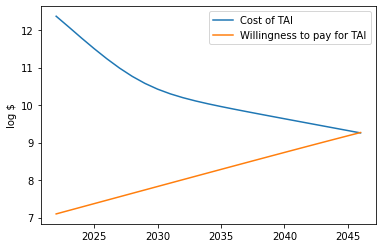

2046: ...Achieved aligned TAI (aligned via work, first attempt), happy future! :D
-
-
-
-
############
## RUN 12 ##
############
Anchor debug:
-- Assume human brain in inference takes 13.2 log FLOP (i.e., 10^13.2 FLOP)
-- Add 0 log FLOP for efficiency
-- Assume a transformative model takes -0.4 log FLOP compared to human
-- Assume a horizon length of 0
-- Assume a scaling exponent of 0.718
-- Assume FLOPs per param per sec of 1.6
-- 25.1 = 13.2 + 0 + -0.4 + 0 + 12 - 0.718 * 11.2 + 0.718 * (13.2 + 0 - 1.6)
-- 25.1 after Bayes update
-
### TAI TIMELINE VARIABLES ###
(Note: `log` refers to `log10`)
It takes 25.1 log FLOPs (~13 septillion) for transformative capabilities.
Every 1.5 years algorithms get 2x better, with 0 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 3.5 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 7.1 log 2022$USD (~13 million) and this increases by 4.1x 

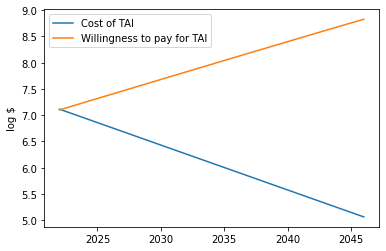

2046: ...Achieved aligned TAI (aligned via work, first attempt), happy future! :D
-
-
-
-
############
## RUN 13 ##
############
Anchor debug:
-- Assume human brain in inference takes 18.5 log FLOP (i.e., 10^18.5 FLOP)
-- Add 2.1 log FLOP for efficiency
-- Assume a transformative model takes -2.1 log FLOP compared to human
-- Assume a horizon length of 0
-- Assume a scaling exponent of 0.52
-- Assume FLOPs per param per sec of 1.8
-- 34.4 = 18.5 + 2.1 + -2.1 + 0 + 12 - 0.52 * 11.2 + 0.52 * (18.5 + 2.1 - 1.8)
-- 34.4 after Bayes update
-
### TAI TIMELINE VARIABLES ###
(Note: `log` refers to `log10`)
It takes 34.4 log FLOPs (~25 decillion) for transformative capabilities.
Every 1.7 years algorithms get 2x better, with 3.4 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 2.2 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 7.1 log 2022$USD (~13 million) and this increases by 4

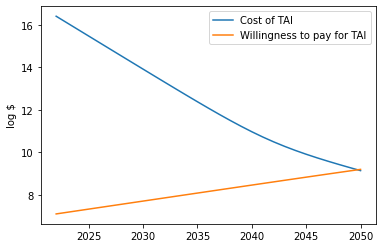

2050: ...Achieved aligned TAI (aligned via work, first attempt), happy future! :D
-
-
-
-
############
## RUN 14 ##
############
Anchor debug:
-- Assume human brain in inference takes 17.7 log FLOP (i.e., 10^17.7 FLOP)
-- Add 2.0 log FLOP for efficiency
-- Assume a transformative model takes -0.7 log FLOP compared to human
-- Assume a horizon length of 0
-- Assume a scaling exponent of 1.112
-- Assume FLOPs per param per sec of 1.5
-- 38.8 = 17.7 + 2.0 + -0.7 + 0 + 12 - 1.112 * 11.2 + 1.112 * (17.7 + 2.0 - 1.5)
-- 38.8 after Bayes update
-
### TAI TIMELINE VARIABLES ###
(Note: `log` refers to `log10`)
It takes 38.8 log FLOPs (~650 thousand decillion) for transformative capabilities.
Every 1.4 years algorithms get 2x better, with 3.5 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 2.9 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 7.1 log 2022$USD (~13 million) and this i

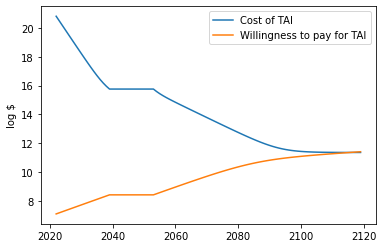

2119: ...Achieved aligned TAI (aligned via work, first attempt), happy future! :D
-
-
-
-
############
## RUN 15 ##
############
Anchor debug:
-- Assume human brain in inference takes 8.6 log FLOP (i.e., 10^8.6 FLOP)
-- Add 1.6 log FLOP for efficiency
-- Assume a transformative model takes 1.3 log FLOP compared to human
-- Assume a horizon length of 0.8
-- Assume a scaling exponent of 0.53
-- Assume FLOPs per param per sec of 1.8
-- 22.9 = 8.6 + 1.6 + 1.3 + 0.8 + 12 - 0.53 * 11.2 + 0.53 * (8.6 + 1.6 - 1.8)
-- 25.5 after Bayes update
-
### TAI TIMELINE VARIABLES ###
(Note: `log` refers to `log10`)
It takes 25.5 log FLOPs (~28 septillion) for transformative capabilities.
Every 1.8 years algorithms get 2x better, with 2.8 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 4.4 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 7.1 log 2022$USD (~13 million) and this increases by 3.

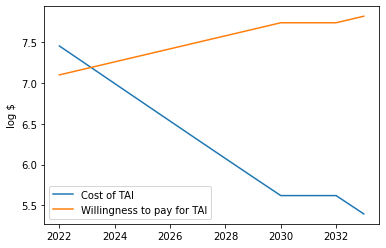

2033: ...XRISK from fully unaligned TAI (singleton) :(
...Singleton is catastrophic
-
-
-
-
############
## RUN 16 ##
############
Anchor debug:
-- Assume human brain in inference takes 14.3 log FLOP (i.e., 10^14.3 FLOP)
-- Add 3.3 log FLOP for efficiency
-- Assume a transformative model takes -0.5 log FLOP compared to human
-- Assume a horizon length of 0
-- Assume a scaling exponent of 1.14
-- Assume FLOPs per param per sec of 1.3
-- 34.8 = 14.3 + 3.3 + -0.5 + 0 + 12 - 1.14 * 11.2 + 1.14 * (14.3 + 3.3 - 1.3)
-- 34.8 after Bayes update
-
### TAI TIMELINE VARIABLES ###
(Note: `log` refers to `log10`)
It takes 34.8 log FLOPs (~69 decillion) for transformative capabilities.
Every 1.7 years algorithms get 2x better, with 3.3 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 3.8 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 7.1 log 2022$USD (~13 million) and this increases by

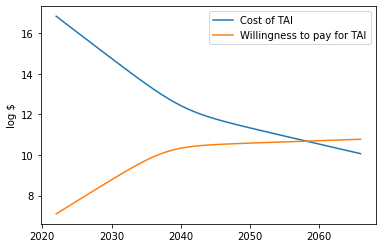

2066: ...Achieved aligned TAI (aligned via work, first attempt), happy future! :D
-
-
-
-
############
## RUN 17 ##
############
Anchor debug:
-- Assume human brain in inference takes 13.5 log FLOP (i.e., 10^13.5 FLOP)
-- Add 0 log FLOP for efficiency
-- Assume a transformative model takes -1.6 log FLOP compared to human
-- Assume a horizon length of 2.0
-- Assume a scaling exponent of 0.801
-- Assume FLOPs per param per sec of 1.1
-- 26.9 = 13.5 + 0 + -1.6 + 2.0 + 12 - 0.801 * 11.2 + 0.801 * (13.5 + 0 - 1.1)
-- 26.9 after Bayes update
-
### TAI TIMELINE VARIABLES ###
(Note: `log` refers to `log10`)
It takes 26.9 log FLOPs (~717 septillion) for transformative capabilities.
Every 1.6 years algorithms get 2x better, with 1.1 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 6.0 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 8.0 log 2022$USD (~92 million) and this increases b

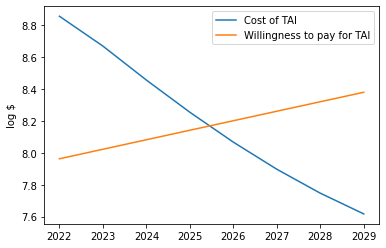

2029: ...Misaligned TAI happened, but it was averted
2030: ...Misaligned TAI happened, it was averted with catastrophe, and we abandon TAI
2031: WAR!!! (US vs. China)
2039: War ends :)
...Boring future
-
-
-
-
############
## RUN 18 ##
############
Anchor debug:
-- Assume human brain in inference takes 18.8 log FLOP (i.e., 10^18.8 FLOP)
-- Add 2.8 log FLOP for efficiency
-- Assume a transformative model takes -1.3 log FLOP compared to human
-- Assume a horizon length of 0
-- Assume a scaling exponent of 1.532
-- Assume FLOPs per param per sec of 1.6
-- 46.0 = 18.8 + 2.8 + -1.3 + 0 + 12 - 1.532 * 11.2 + 1.532 * (18.8 + 2.8 - 1.6)
-- 46.0 after Bayes update
-
### TAI TIMELINE VARIABLES ###
(Note: `log` refers to `log10`)
It takes 46.0 log FLOPs (~10 trillion decillion) for transformative capabilities.
Every 1.6 years algorithms get 2x better, with 2.8 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 2.1 years they get 2x cheaper, to a 

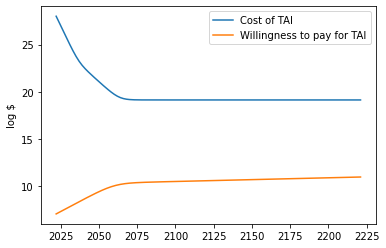

-
-
-
-
############
## RUN 19 ##
############
Anchor debug:
-- Assume human brain in inference takes 14.9 log FLOP (i.e., 10^14.9 FLOP)
-- Add 3.8 log FLOP for efficiency
-- Assume a transformative model takes -1.7 log FLOP compared to human
-- Assume a horizon length of 3.7
-- Assume a scaling exponent of 1.479
-- Assume FLOPs per param per sec of 1.4
-- 41.5 = 14.9 + 3.8 + -1.7 + 3.7 + 12 - 1.479 * 11.2 + 1.479 * (14.9 + 3.8 - 1.4)
-- 41.5 after Bayes update
-
### TAI TIMELINE VARIABLES ###
(Note: `log` refers to `log10`)
It takes 41.5 log FLOPs (~329 million decillion) for transformative capabilities.
Every 1.4 years algorithms get 2x better, with 5.4 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 3.1 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 7.1 log 2022$USD (~13 million) and this increases by 3.8x per year to a max of 3e-05% of GDP. GDP grows at a rate of 1.0

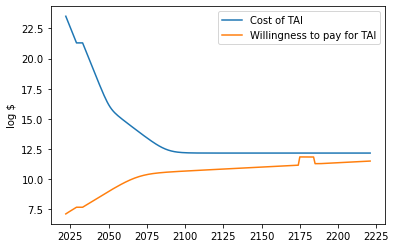

-
-
-
-
############
## RUN 20 ##
############
Anchor debug:
-- Assume human brain in inference takes 19.8 log FLOP (i.e., 10^19.8 FLOP)
-- Add 3.1 log FLOP for efficiency
-- Assume a transformative model takes -1.3 log FLOP compared to human
-- Assume a horizon length of 3.6
-- Assume a scaling exponent of 1.223
-- Assume FLOPs per param per sec of 1.2
-- 50.2 = 19.8 + 3.1 + -1.3 + 3.6 + 12 - 1.223 * 11.2 + 1.223 * (19.8 + 3.1 - 1.2)
-- 50.2 after Bayes update
-
### TAI TIMELINE VARIABLES ###
(Note: `log` refers to `log10`)
It takes 50.2 log FLOPs (~169 quadrillion decillion) for transformative capabilities.
Every 1.5 years algorithms get 2x better, with 4.5 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 3.1 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 8.5 log 2022$USD (~306 million) and this increases by 5.4x per year to a max of 0.00107% of GDP. GDP grows at a rate

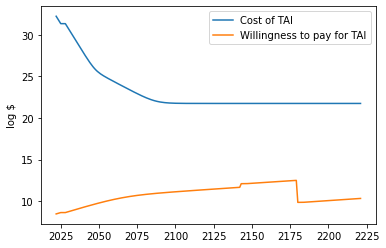

-
-
-
-
############
## RUN 21 ##
############
Anchor debug:
-- Assume human brain in inference takes 19.3 log FLOP (i.e., 10^19.3 FLOP)
-- Add 1.2 log FLOP for efficiency
-- Assume a transformative model takes -0.5 log FLOP compared to human
-- Assume a horizon length of 9.3
-- Assume a scaling exponent of 0.996
-- Assume FLOPs per param per sec of 1.3
-- 49.3 = 19.3 + 1.2 + -0.5 + 9.3 + 12 - 0.996 * 11.2 + 0.996 * (19.3 + 1.2 - 1.3)
-- 49.3 after Bayes update
-
### TAI TIMELINE VARIABLES ###
(Note: `log` refers to `log10`)
It takes 49.3 log FLOPs (~20 quadrillion decillion) for transformative capabilities.
Every 1.2 years algorithms get 2x better, with 2.7 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 3.1 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 7.1 log 2022$USD (~13 million) and this increases by 1.5x per year to a max of 0.00058% of GDP. GDP grows at a rate o

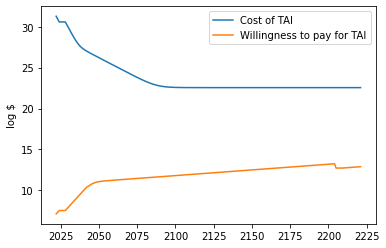

-
-
-
-
############
## RUN 22 ##
############
Anchor debug:
-- Assume human brain in inference takes 9.8 log FLOP (i.e., 10^9.8 FLOP)
-- Add 0 log FLOP for efficiency
-- Assume a transformative model takes 0.1 log FLOP compared to human
-- Assume a horizon length of 0
-- Assume a scaling exponent of 1.129
-- Assume FLOPs per param per sec of 1.4
-- 18.8 = 9.8 + 0 + 0.1 + 0 + 12 - 1.129 * 11.2 + 1.129 * (9.8 + 0 - 1.4)
-- 20.9 after Bayes update
-
### TAI TIMELINE VARIABLES ###
(Note: `log` refers to `log10`)
It takes 20.9 log FLOPs (~778 quintillion) for transformative capabilities.
Every 2.1 years algorithms get 2x better, with 1.5 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 3.6 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 7.1 log 2022$USD (~13 million) and this increases by 1.7x per year to a max of 0.00074% of GDP. GDP grows at a rate of 1.026x per year.
If a n

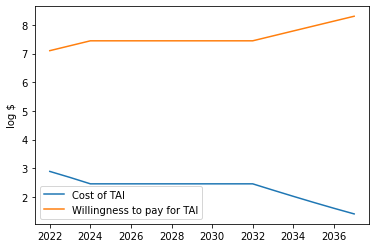

2037: ...XRISK from intentional misuse of TAI (singleton) :(
...Singleton is catastrophic
-
-
-
-
############
## RUN 23 ##
############
Anchor debug:
-- Assume human brain in inference takes 14.4 log FLOP (i.e., 10^14.4 FLOP)
-- Add 2.1 log FLOP for efficiency
-- Assume a transformative model takes -0.8 log FLOP compared to human
-- Assume a horizon length of 2.0
-- Assume a scaling exponent of 1.27
-- Assume FLOPs per param per sec of 2.0
-- 34.1 = 14.4 + 2.1 + -0.8 + 2.0 + 12 - 1.27 * 11.2 + 1.27 * (14.4 + 2.1 - 2.0)
-- 34.1 after Bayes update
-
### TAI TIMELINE VARIABLES ###
(Note: `log` refers to `log10`)
It takes 34.1 log FLOPs (~12 decillion) for transformative capabilities.
Every 1.7 years algorithms get 2x better, with 4.4 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 3.3 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 7.1 log 2022$USD (~13 million) and this in

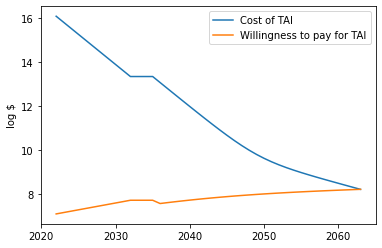

2063: ...XRISK from fully unaligned TAI (extinction) :(
-
-
-
-
############
## RUN 24 ##
############
Anchor debug:
-- Assume human brain in inference takes 12.9 log FLOP (i.e., 10^12.9 FLOP)
-- Add 0 log FLOP for efficiency
-- Assume a transformative model takes -0.8 log FLOP compared to human
-- Assume a horizon length of 0
-- Assume a scaling exponent of 0.548
-- Assume FLOPs per param per sec of 2.0
-- 23.9 = 12.9 + 0 + -0.8 + 0 + 12 - 0.548 * 11.2 + 0.548 * (12.9 + 0 - 2.0)
-- 25.8 after Bayes update
-
### TAI TIMELINE VARIABLES ###
(Note: `log` refers to `log10`)
It takes 25.8 log FLOPs (~64 septillion) for transformative capabilities.
Every 1.7 years algorithms get 2x better, with 0 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 2.6 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 8.4 log 2022$USD (~262 million) and this increases by 1.7x per year to a max of 0.00

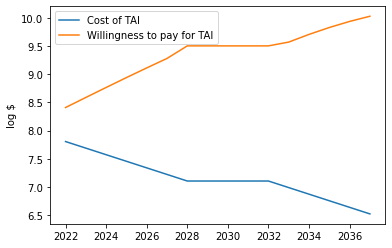

2037: ...Achieved aligned TAI (aligned via work, first attempt), happy future! :D
-
-
-
-
############
## RUN 25 ##
############
Anchor debug:
-- Assume human brain in inference takes 13.8 log FLOP (i.e., 10^13.8 FLOP)
-- Add 3.2 log FLOP for efficiency
-- Assume a transformative model takes -0.3 log FLOP compared to human
-- Assume a horizon length of 0
-- Assume a scaling exponent of 1.113
-- Assume FLOPs per param per sec of 1.8
-- 33.1 = 13.8 + 3.2 + -0.3 + 0 + 12 - 1.113 * 11.2 + 1.113 * (13.8 + 3.2 - 1.8)
-- 33.1 after Bayes update
-
### TAI TIMELINE VARIABLES ###
(Note: `log` refers to `log10`)
It takes 33.1 log FLOPs (~1 decillion) for transformative capabilities.
Every 1.6 years algorithms get 2x better, with 4.2 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 4.5 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 8.7 log 2022$USD (~486 million) and this increases b

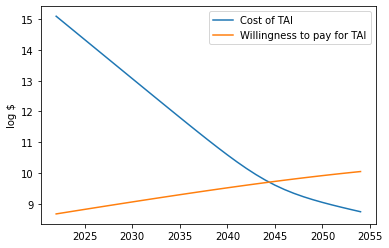

2054: ...XRISK from fully unaligned TAI (extinction) :(
-
-
-
-
############
## RUN 26 ##
############
Anchor debug:
-- Assume human brain in inference takes 13.2 log FLOP (i.e., 10^13.2 FLOP)
-- Add 0.5 log FLOP for efficiency
-- Assume a transformative model takes -0.0 log FLOP compared to human
-- Assume a horizon length of 0
-- Assume a scaling exponent of 1.345
-- Assume FLOPs per param per sec of 1.6
-- 26.8 = 13.2 + 0.5 + -0.0 + 0 + 12 - 1.345 * 11.2 + 1.345 * (13.2 + 0.5 - 1.6)
-- 26.8 after Bayes update
-
### TAI TIMELINE VARIABLES ###
(Note: `log` refers to `log10`)
It takes 26.8 log FLOPs (~630 septillion) for transformative capabilities.
Every 1.6 years algorithms get 2x better, with 2.5 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 2.7 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 7.1 log 2022$USD (~13 million) and this increases by 3.7x per year to a max

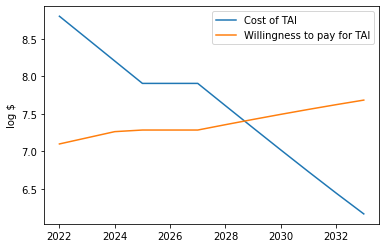

2033: ...XRISK from fully unaligned TAI (singleton) :(
-
-
-
-
############
## RUN 27 ##
############
Anchor debug:
-- Assume human brain in inference takes 13.9 log FLOP (i.e., 10^13.9 FLOP)
-- Add 2.5 log FLOP for efficiency
-- Assume a transformative model takes -1.4 log FLOP compared to human
-- Assume a horizon length of 2.1
-- Assume a scaling exponent of 0.542
-- Assume FLOPs per param per sec of 1.4
-- 31.2 = 13.9 + 2.5 + -1.4 + 2.1 + 12 - 0.542 * 11.2 + 0.542 * (13.9 + 2.5 - 1.4)
-- 31.2 after Bayes update
-
### TAI TIMELINE VARIABLES ###
(Note: `log` refers to `log10`)
It takes 31.2 log FLOPs (~15 nonillion) for transformative capabilities.
Every 1.7 years algorithms get 2x better, with 3.6 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 2.4 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 7.4 log 2022$USD (~27 million) and this increases by 4.5x per year to a ma

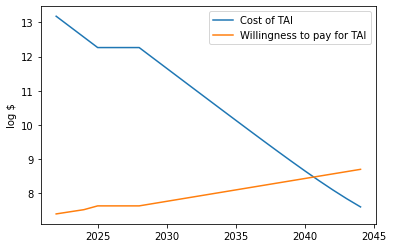

2044: ...XRISK from fully unaligned TAI (extinction) :(
-
-
-
-
############
## RUN 28 ##
############
Anchor debug:
-- Assume human brain in inference takes 13.0 log FLOP (i.e., 10^13.0 FLOP)
-- Add 3.5 log FLOP for efficiency
-- Assume a transformative model takes -1.8 log FLOP compared to human
-- Assume a horizon length of 0
-- Assume a scaling exponent of 0.863
-- Assume FLOPs per param per sec of 1.8
-- 29.9 = 13.0 + 3.5 + -1.8 + 0 + 12 - 0.863 * 11.2 + 0.863 * (13.0 + 3.5 - 1.8)
-- 29.9 after Bayes update
-
### TAI TIMELINE VARIABLES ###
(Note: `log` refers to `log10`)
It takes 29.9 log FLOPs (~762 octillion) for transformative capabilities.
Every 2.3 years algorithms get 2x better, with 4.4 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 2.6 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 7.1 log 2022$USD (~13 million) and this increases by 3.3x per year to a max 

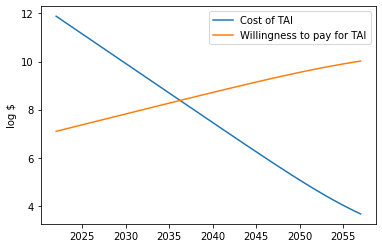

2057: ...XRISK from subtly unaligned TAI :(
-
-
-
-
############
## RUN 29 ##
############
Anchor debug:
-- Assume human brain in inference takes 12.0 log FLOP (i.e., 10^12.0 FLOP)
-- Add 1.3 log FLOP for efficiency
-- Assume a transformative model takes 0.1 log FLOP compared to human
-- Assume a horizon length of 0
-- Assume a scaling exponent of 1.207
-- Assume FLOPs per param per sec of 1.1
-- 26.6 = 12.0 + 1.3 + 0.1 + 0 + 12 - 1.207 * 11.2 + 1.207 * (12.0 + 1.3 - 1.1)
-- 26.6 after Bayes update
-
### TAI TIMELINE VARIABLES ###
(Note: `log` refers to `log10`)
It takes 26.6 log FLOPs (~389 septillion) for transformative capabilities.
Every 2.5 years algorithms get 2x better, with 1.3 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 2.8 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 7.1 log 2022$USD (~13 million) and this increases by 2.8x per year to a max of 0.00064% o

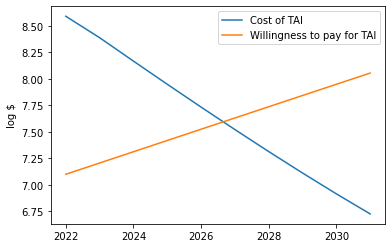

2031: ...XRISK from fully unaligned TAI (singleton) :(
...Singleton is catastrophic
-
-
-
-
############
## RUN 30 ##
############
Anchor debug:
-- Assume human brain in inference takes 15.9 log FLOP (i.e., 10^15.9 FLOP)
-- Add 3.1 log FLOP for efficiency
-- Assume a transformative model takes -1.1 log FLOP compared to human
-- Assume a horizon length of 0
-- Assume a scaling exponent of 1.034
-- Assume FLOPs per param per sec of 1.4
-- 36.4 = 15.9 + 3.1 + -1.1 + 0 + 12 - 1.034 * 11.2 + 1.034 * (15.9 + 3.1 - 1.4)
-- 36.4 after Bayes update
-
### TAI TIMELINE VARIABLES ###
(Note: `log` refers to `log10`)
It takes 36.4 log FLOPs (~3 thousand decillion) for transformative capabilities.
Every 1.3 years algorithms get 2x better, with 3.1 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 2.4 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 7.1 log 2022$USD (~13 million) and this i

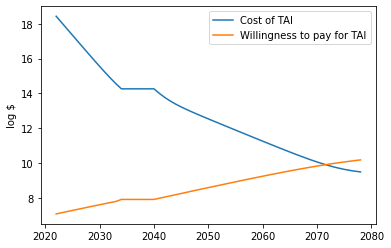

2078: ...Achieved aligned TAI (aligned via work, first attempt), happy future! :D
-
-
-
-
############
## RUN 31 ##
############
Anchor debug:
-- Assume human brain in inference takes 18.1 log FLOP (i.e., 10^18.1 FLOP)
-- Add 1.1 log FLOP for efficiency
-- Assume a transformative model takes -0.3 log FLOP compared to human
-- Assume a horizon length of 0
-- Assume a scaling exponent of 1.314
-- Assume FLOPs per param per sec of 2.0
-- 39.0 = 18.1 + 1.1 + -0.3 + 0 + 12 - 1.314 * 11.2 + 1.314 * (18.1 + 1.1 - 2.0)
-- 39.0 after Bayes update
-
### TAI TIMELINE VARIABLES ###
(Note: `log` refers to `log10`)
It takes 39.0 log FLOPs (~895 thousand decillion) for transformative capabilities.
Every 1.5 years algorithms get 2x better, with 2.5 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 2.2 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 7.5 log 2022$USD (~34 million) and this i

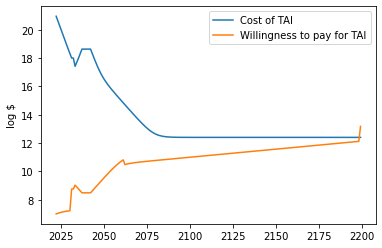

2199: ...Achieved aligned TAI (aligned via work, first attempt), happy future! :D
-
-
-
-
############
## RUN 32 ##
############
Anchor debug:
-- Assume human brain in inference takes 12.7 log FLOP (i.e., 10^12.7 FLOP)
-- Add 1.3 log FLOP for efficiency
-- Assume a transformative model takes -1.8 log FLOP compared to human
-- Assume a horizon length of 0
-- Assume a scaling exponent of 0.621
-- Assume FLOPs per param per sec of 2.1
-- 24.7 = 12.7 + 1.3 + -1.8 + 0 + 12 - 0.621 * 11.2 + 0.621 * (12.7 + 1.3 - 2.1)
-- 26.4 after Bayes update
-
### TAI TIMELINE VARIABLES ###
(Note: `log` refers to `log10`)
It takes 26.4 log FLOPs (~263 septillion) for transformative capabilities.
Every 1.8 years algorithms get 2x better, with 2.4 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 2.6 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 7.1 log 2022$USD (~13 million) and this increases

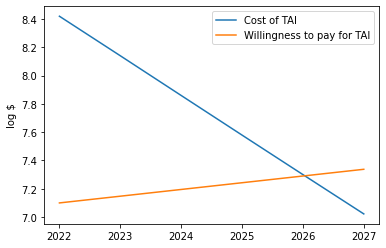

2027: ...XRISK from fully unaligned TAI (singleton) :(
-
-
-
-
############
## RUN 33 ##
############
Anchor debug:
-- Assume human brain in inference takes 15.8 log FLOP (i.e., 10^15.8 FLOP)
-- Add 1.6 log FLOP for efficiency
-- Assume a transformative model takes -1.7 log FLOP compared to human
-- Assume a horizon length of 10.8
-- Assume a scaling exponent of 1.273
-- Assume FLOPs per param per sec of 1.6
-- 44.5 = 15.8 + 1.6 + -1.7 + 10.8 + 12 - 1.273 * 11.2 + 1.273 * (15.8 + 1.6 - 1.6)
-- 44.5 after Bayes update
-
### TAI TIMELINE VARIABLES ###
(Note: `log` refers to `log10`)
It takes 44.5 log FLOPs (~321 billion decillion) for transformative capabilities.
Every 1.0 years algorithms get 2x better, with 3.8 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 2.7 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 7.1 log 2022$USD (~13 million) and this increases by 4.8x per y

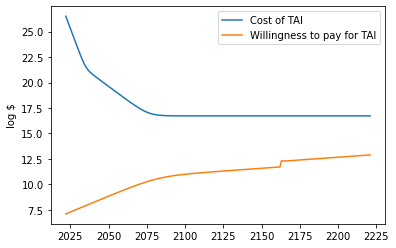

-
-
-
-
############
## RUN 34 ##
############
Anchor debug:
-- Assume human brain in inference takes 13.5 log FLOP (i.e., 10^13.5 FLOP)
-- Add 2.0 log FLOP for efficiency
-- Assume a transformative model takes -1.1 log FLOP compared to human
-- Assume a horizon length of 0
-- Assume a scaling exponent of 1.459
-- Assume FLOPs per param per sec of 1.1
-- 31.2 = 13.5 + 2.0 + -1.1 + 0 + 12 - 1.459 * 11.2 + 1.459 * (13.5 + 2.0 - 1.1)
-- 31.2 after Bayes update
-
### TAI TIMELINE VARIABLES ###
(Note: `log` refers to `log10`)
It takes 31.2 log FLOPs (~16 nonillion) for transformative capabilities.
Every 2.6 years algorithms get 2x better, with 2.0 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 2.9 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 7.1 log 2022$USD (~13 million) and this increases by 1.3x per year to a max of 0.00059% of GDP. GDP grows at a rate of 1.018x per yea

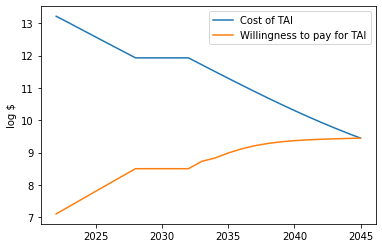

2045: ...Achieved aligned TAI (aligned via work, first attempt), happy future! :D
-
-
-
-
############
## RUN 35 ##
############
Anchor debug:
-- Assume human brain in inference takes 19.8 log FLOP (i.e., 10^19.8 FLOP)
-- Add 1.8 log FLOP for efficiency
-- Assume a transformative model takes -0.6 log FLOP compared to human
-- Assume a horizon length of 4.9
-- Assume a scaling exponent of 1.06
-- Assume FLOPs per param per sec of 2.7
-- 46.0 = 19.8 + 1.8 + -0.6 + 4.9 + 12 - 1.06 * 11.2 + 1.06 * (19.8 + 1.8 - 2.7)
-- 46.0 after Bayes update
-
### TAI TIMELINE VARIABLES ###
(Note: `log` refers to `log10`)
It takes 46.0 log FLOPs (~10 trillion decillion) for transformative capabilities.
Every 1.8 years algorithms get 2x better, with 2.9 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 4.6 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 7.1 log 2022$USD (~13 million) and this i

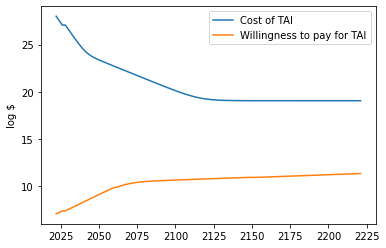

-
-
-
-
############
## RUN 36 ##
############
Anchor debug:
-- Assume human brain in inference takes 21.8 log FLOP (i.e., 10^21.8 FLOP)
-- Add 4.1 log FLOP for efficiency
-- Assume a transformative model takes -1.1 log FLOP compared to human
-- Assume a horizon length of 0
-- Assume a scaling exponent of 0.881
-- Assume FLOPs per param per sec of 1.1
-- 48.7 = 21.8 + 4.1 + -1.1 + 0 + 12 - 0.881 * 11.2 + 0.881 * (21.8 + 4.1 - 1.1)
-- 48.7 after Bayes update
-
### TAI TIMELINE VARIABLES ###
(Note: `log` refers to `log10`)
It takes 48.7 log FLOPs (~5 quadrillion decillion) for transformative capabilities.
Every 1.1 years algorithms get 2x better, with 4.6 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 4.3 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 7.1 log 2022$USD (~13 million) and this increases by 4.0x per year to a max of 2e-05% of GDP. GDP grows at a rate of 1.017

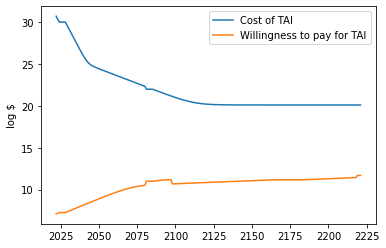

-
-
-
-
############
## RUN 37 ##
############
Anchor debug:
-- Assume human brain in inference takes 11.0 log FLOP (i.e., 10^11.0 FLOP)
-- Add 1.2 log FLOP for efficiency
-- Assume a transformative model takes 1.0 log FLOP compared to human
-- Assume a horizon length of 2.4
-- Assume a scaling exponent of 0.911
-- Assume FLOPs per param per sec of 1.5
-- 27.2 = 11.0 + 1.2 + 1.0 + 2.4 + 12 - 0.911 * 11.2 + 0.911 * (11.0 + 1.2 - 1.5)
-- 27.2 after Bayes update
-
### TAI TIMELINE VARIABLES ###
(Note: `log` refers to `log10`)
It takes 27.2 log FLOPs (~2 octillion) for transformative capabilities.
Every 1.7 years algorithms get 2x better, with 1.2 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 2.3 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 7.1 log 2022$USD (~13 million) and this increases by 5.0x per year to a max of 0.0004% of GDP. GDP grows at a rate of 1.026x per yea

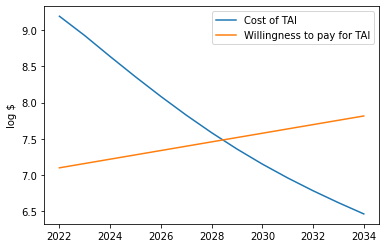

2034: ...XRISK from fully unaligned TAI (singleton) :(
...Singleton is catastrophic
-
-
-
-
############
## RUN 38 ##
############
Anchor debug:
-- Assume human brain in inference takes 14.5 log FLOP (i.e., 10^14.5 FLOP)
-- Add 0 log FLOP for efficiency
-- Assume a transformative model takes -0.4 log FLOP compared to human
-- Assume a horizon length of 0
-- Assume a scaling exponent of 1.122
-- Assume FLOPs per param per sec of 1.0
-- 28.6 = 14.5 + 0 + -0.4 + 0 + 12 - 1.122 * 11.2 + 1.122 * (14.5 + 0 - 1.0)
-- 28.6 after Bayes update
-
### TAI TIMELINE VARIABLES ###
(Note: `log` refers to `log10`)
It takes 28.6 log FLOPs (~42 octillion) for transformative capabilities.
Every 1.9 years algorithms get 2x better, with 0 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 2.2 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 7.1 log 2022$USD (~13 million) and this increases by 4.6x

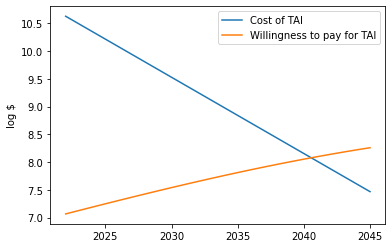

2045: ...Tool TAI made
...Boring future
-
-
-
-
############
## RUN 39 ##
############
Anchor debug:
-- Assume human brain in inference takes 16.1 log FLOP (i.e., 10^16.1 FLOP)
-- Add 1.1 log FLOP for efficiency
-- Assume a transformative model takes -0.0 log FLOP compared to human
-- Assume a horizon length of 3.3
-- Assume a scaling exponent of 1.094
-- Assume FLOPs per param per sec of 1.5
-- 37.3 = 16.1 + 1.1 + -0.0 + 3.3 + 12 - 1.094 * 11.2 + 1.094 * (16.1 + 1.1 - 1.5)
-- 37.3 after Bayes update
-
### TAI TIMELINE VARIABLES ###
(Note: `log` refers to `log10`)
It takes 37.3 log FLOPs (~19 thousand decillion) for transformative capabilities.
Every 1.7 years algorithms get 2x better, with 1.1 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 2.6 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 7.5 log 2022$USD (~31 million) and this increases by 3.7x per year to a max of 1

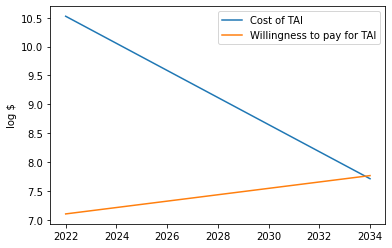

2034: ...Achieved aligned TAI (aligned via work, first attempt), happy future! :D
-
-
-
-
############
## RUN 41 ##
############
Anchor debug:
-- Assume human brain in inference takes 15.0 log FLOP (i.e., 10^15.0 FLOP)
-- Add 1.8 log FLOP for efficiency
-- Assume a transformative model takes -0.7 log FLOP compared to human
-- Assume a horizon length of 1.2
-- Assume a scaling exponent of 0.818
-- Assume FLOPs per param per sec of 1.4
-- 32.7 = 15.0 + 1.8 + -0.7 + 1.2 + 12 - 0.818 * 11.2 + 0.818 * (15.0 + 1.8 - 1.4)
-- 32.7 after Bayes update
-
### TAI TIMELINE VARIABLES ###
(Note: `log` refers to `log10`)
It takes 32.7 log FLOPs (~547 nonillion) for transformative capabilities.
Every 1.2 years algorithms get 2x better, with 1.8 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 3.0 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 7.1 log 2022$USD (~13 million) and this increa

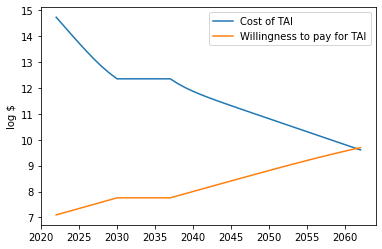

2062: ...Achieved aligned TAI (aligned via work, first attempt), happy future! :D
-
-
-
-
############
## RUN 42 ##
############
Anchor debug:
-- Assume human brain in inference takes 13.9 log FLOP (i.e., 10^13.9 FLOP)
-- Add 1.4 log FLOP for efficiency
-- Assume a transformative model takes -0.8 log FLOP compared to human
-- Assume a horizon length of 10.9
-- Assume a scaling exponent of 0.609
-- Assume FLOPs per param per sec of 1.1
-- 39.1 = 13.9 + 1.4 + -0.8 + 10.9 + 12 - 0.609 * 11.2 + 0.609 * (13.9 + 1.4 - 1.1)
-- 39.1 after Bayes update
-
### TAI TIMELINE VARIABLES ###
(Note: `log` refers to `log10`)
It takes 39.1 log FLOPs (~1 million decillion) for transformative capabilities.
Every 1.7 years algorithms get 2x better, with 0.7 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 4.5 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 7.1 log 2022$USD (~13 million) and thi

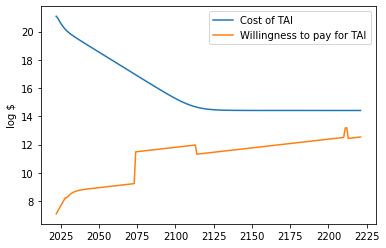

-
-
-
-
############
## RUN 43 ##
############
Anchor debug:
-- Assume human brain in inference takes 14.1 log FLOP (i.e., 10^14.1 FLOP)
-- Add 2.0 log FLOP for efficiency
-- Assume a transformative model takes 0.4 log FLOP compared to human
-- Assume a horizon length of 6.7
-- Assume a scaling exponent of 1.363
-- Assume FLOPs per param per sec of 1.3
-- 40.1 = 14.1 + 2.0 + 0.4 + 6.7 + 12 - 1.363 * 11.2 + 1.363 * (14.1 + 2.0 - 1.3)
-- 40.1 after Bayes update
-
### TAI TIMELINE VARIABLES ###
(Note: `log` refers to `log10`)
It takes 40.1 log FLOPs (~12 million decillion) for transformative capabilities.
Every 1.6 years algorithms get 2x better, with 2.2 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 2.7 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 7.1 log 2022$USD (~13 million) and this increases by 4.7x per year to a max of 2e-05% of GDP. GDP grows at a rate of 1.026x

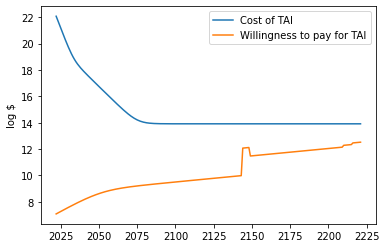

-
-
-
-
############
## RUN 44 ##
############
Anchor debug:
-- Assume human brain in inference takes 13.9 log FLOP (i.e., 10^13.9 FLOP)
-- Add 1.0 log FLOP for efficiency
-- Assume a transformative model takes -0.5 log FLOP compared to human
-- Assume a horizon length of 0
-- Assume a scaling exponent of 1.145
-- Assume FLOPs per param per sec of 1.6
-- 28.7 = 13.9 + 1.0 + -0.5 + 0 + 12 - 1.145 * 11.2 + 1.145 * (13.9 + 1.0 - 1.6)
-- 28.7 after Bayes update
-
### TAI TIMELINE VARIABLES ###
(Note: `log` refers to `log10`)
It takes 28.7 log FLOPs (~52 octillion) for transformative capabilities.
Every 2.2 years algorithms get 2x better, with 1.9 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 6.2 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 7.1 log 2022$USD (~13 million) and this increases by 5.2x per year to a max of 3e-05% of GDP. GDP grows at a rate of 1.03x per year.


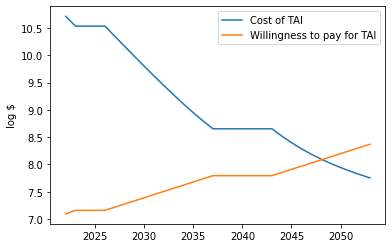

2053: ...Achieved aligned TAI (aligned via work, first attempt), happy future! :D
-
-
-
-
############
## RUN 45 ##
############
Anchor debug:
-- Assume human brain in inference takes 15.2 log FLOP (i.e., 10^15.2 FLOP)
-- Add 1.7 log FLOP for efficiency
-- Assume a transformative model takes 0.4 log FLOP compared to human
-- Assume a horizon length of 1.3
-- Assume a scaling exponent of 1.202
-- Assume FLOPs per param per sec of 1.7
-- 35.5 = 15.2 + 1.7 + 0.4 + 1.3 + 12 - 1.202 * 11.2 + 1.202 * (15.2 + 1.7 - 1.7)
-- 35.5 after Bayes update
-
### TAI TIMELINE VARIABLES ###
(Note: `log` refers to `log10`)
It takes 35.5 log FLOPs (~352 decillion) for transformative capabilities.
Every 1.5 years algorithms get 2x better, with 1.7 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 3.7 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 7.1 log 2022$USD (~13 million) and this increase

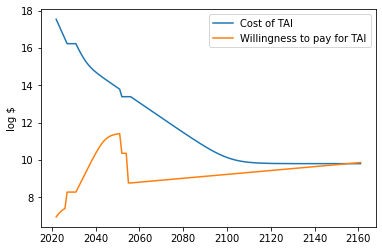

2161: ...Achieved aligned TAI (aligned via work, first attempt), happy future! :D
-
-
-
-
############
## RUN 46 ##
############
Anchor debug:
-- Assume human brain in inference takes 13.3 log FLOP (i.e., 10^13.3 FLOP)
-- Add 1.6 log FLOP for efficiency
-- Assume a transformative model takes 0.1 log FLOP compared to human
-- Assume a horizon length of 1.4
-- Assume a scaling exponent of 0.619
-- Assume FLOPs per param per sec of 1.2
-- 30.1 = 13.3 + 1.6 + 0.1 + 1.4 + 12 - 0.619 * 11.2 + 0.619 * (13.3 + 1.6 - 1.2)
-- 30.1 after Bayes update
-
### TAI TIMELINE VARIABLES ###
(Note: `log` refers to `log10`)
It takes 30.1 log FLOPs (~1 nonillion) for transformative capabilities.
Every 1.6 years algorithms get 2x better, with 3.5 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 4.5 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 7.1 log 2022$USD (~13 million) and this increases 

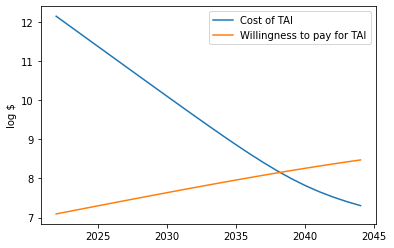

2044: ...XRISK from fully unaligned TAI (extinction) :(
-
-
-
-
############
## RUN 47 ##
############
Anchor debug:
-- Assume human brain in inference takes 14.0 log FLOP (i.e., 10^14.0 FLOP)
-- Add 2.4 log FLOP for efficiency
-- Assume a transformative model takes 0.3 log FLOP compared to human
-- Assume a horizon length of 2.4
-- Assume a scaling exponent of 1.3
-- Assume FLOPs per param per sec of 1.5
-- 36.0 = 14.0 + 2.4 + 0.3 + 2.4 + 12 - 1.3 * 11.2 + 1.3 * (14.0 + 2.4 - 1.5)
-- 36.0 after Bayes update
-
### TAI TIMELINE VARIABLES ###
(Note: `log` refers to `log10`)
It takes 36.0 log FLOPs (~898 decillion) for transformative capabilities.
Every 1.8 years algorithms get 2x better, with 4.1 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 2.8 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 7.1 log 2022$USD (~13 million) and this increases by 6.3x per year to a max of 0

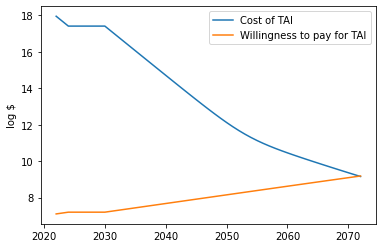

2072: ...XRISK from subtly unaligned TAI :(
-
-
-
-
############
## RUN 48 ##
############
Anchor debug:
-- Assume human brain in inference takes 16.5 log FLOP (i.e., 10^16.5 FLOP)
-- Add 0.9 log FLOP for efficiency
-- Assume a transformative model takes -0.6 log FLOP compared to human
-- Assume a horizon length of 0
-- Assume a scaling exponent of 1.121
-- Assume FLOPs per param per sec of 1.7
-- 33.8 = 16.5 + 0.9 + -0.6 + 0 + 12 - 1.121 * 11.2 + 1.121 * (16.5 + 0.9 - 1.7)
-- 33.8 after Bayes update
-
### TAI TIMELINE VARIABLES ###
(Note: `log` refers to `log10`)
It takes 33.8 log FLOPs (~7 decillion) for transformative capabilities.
Every 1.2 years algorithms get 2x better, with 0.9 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 4.1 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 7.7 log 2022$USD (~53 million) and this increases by 1.8x per year to a max of 0.0007% of 

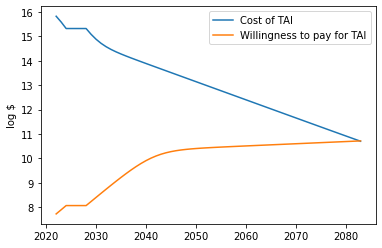

2083: ...Achieved aligned TAI (aligned via work, first attempt), happy future! :D
-
-
-
-
############
## RUN 49 ##
############
Anchor debug:
-- Assume human brain in inference takes 13.2 log FLOP (i.e., 10^13.2 FLOP)
-- Add 2.0 log FLOP for efficiency
-- Assume a transformative model takes -1.6 log FLOP compared to human
-- Assume a horizon length of 4.7
-- Assume a scaling exponent of 0.55
-- Assume FLOPs per param per sec of 1.9
-- 31.3 = 13.2 + 2.0 + -1.6 + 4.7 + 12 - 0.55 * 11.2 + 0.55 * (13.2 + 2.0 - 1.9)
-- 31.3 after Bayes update
-
### TAI TIMELINE VARIABLES ###
(Note: `log` refers to `log10`)
It takes 31.3 log FLOPs (~21 nonillion) for transformative capabilities.
Every 1.2 years algorithms get 2x better, with 2.8 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 3.0 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 8.2 log 2022$USD (~141 million) and this increases

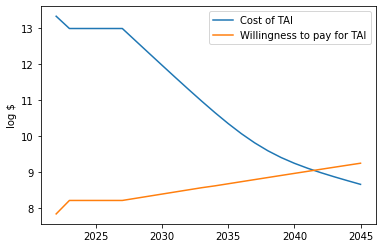

2045: ...XRISK from fully unaligned TAI (singleton) :(
...Singleton is catastrophic
-
-
-
-
############
## RUN 50 ##
############
Anchor debug:
-- Assume human brain in inference takes 15.6 log FLOP (i.e., 10^15.6 FLOP)
-- Add 2.5 log FLOP for efficiency
-- Assume a transformative model takes -0.3 log FLOP compared to human
-- Assume a horizon length of 8.1
-- Assume a scaling exponent of 0.378
-- Assume FLOPs per param per sec of 1.4
-- 39.9 = 15.6 + 2.5 + -0.3 + 8.1 + 12 - 0.378 * 11.2 + 0.378 * (15.6 + 2.5 - 1.4)
-- 39.9 after Bayes update
-
### TAI TIMELINE VARIABLES ###
(Note: `log` refers to `log10`)
It takes 39.9 log FLOPs (~8 million decillion) for transformative capabilities.
Every 1.7 years algorithms get 2x better, with 2.5 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 2.7 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 7.1 log 2022$USD (~13 million) and thi

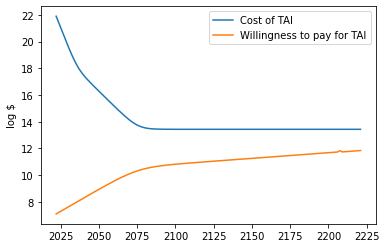

-
-


In [18]:
for i in range(50):
    print('-')
    print('-')
    print('############')
    print('## RUN {} ##'.format(i + 1))
    print('############')
    define_event(verbosity=2)

In [ ]:
collectors = bayes.bayesnet(define_event,
                            find=lambda e: e['collectors'],
                            raw=True, verbose=True, n=RUNS)

Checking cache...
Generating Bayes net...


 50%|████████████████████████████▋                             | 49532/100000 [16:31<16:05, 52.30it/s]

In [ ]:
def print_states(states):
    c = Counter(states)
    c = dict([(k, round(v / RUNS * 100, 3)) for k, v in c.items()])
    for k in c.keys():
        if k not in STATES:
            raise ValueError('State {} not in `STATES`'.format(k))
    for state in STATES:
        if not c.get(state):
            c[state] = 0.0
    c = sorted(c.items(), key=lambda x: x[1], reverse=True)
    return c


print('0. World State At Year')
for y_c in [2030, 2050, 2070, 2100, 2200]:
    print('## {} ##'.format(y_c)) 
    pprint(print_states([c[y_c]['category'] for c in collectors]))
    print('-')
    print('-')

In [ ]:
print('0B. Catastrophe States At Year')

def print_catastrophe(catastrophes):
    c = Counter([' '.join(sorted(c)) for c in catastrophes])
    c = dict([(k, round(v / RUNS * 100, 2)) for k, v in c.items()])
    c = sorted(c.items(), key=lambda x: x[1], reverse=True)
    c = [c_ for c_ in c if c_[1] >= 0.1]
    return c

for y_c in [2023, 2030, 2050, 2070, 2100, 2200]:
    print('## {} ##'.format(y_c))  
    pprint(print_catastrophe([c[y_c]['catastrophe'] for c in collectors]))
    print('-')
    print('-')

In [ ]:
print('0C. *First* Catastrophe State At Year')

def print_catastrophe_first(catastrophes):
    c = Counter([c[0] if len(c) > 0 else '' for c in catastrophes])
    c = dict([(k, round(v / RUNS * 100, 2)) for k, v in c.items()])
    c = sorted(c.items(), key=lambda x: x[1], reverse=True)
    c = [c_ for c_ in c if c_[1] >= 0.1]
    return c

for y_c in [2023, 2030, 2050, 2070, 2100, 2200]:
    print('## {} ##'.format(y_c))  
    pprint(print_catastrophe_first([c[y_c]['catastrophe'] for c in collectors]))
    print('-')
    print('-')

In [ ]:
print('0D. Double Catastrophe X-Risks')

def print_double_catastrophes(catastrophes):
    c = Counter(['' if c is None else c for c in catastrophes])
    c = dict([(k, round(v / RUNS * 100, 3)) for k, v in c.items()])
    c = sorted(c.items(), key=lambda x: x[1], reverse=True)
    # c = [c_ for c_ in c if c_[1] >= 0.1]
    return c

for y_c in [2030, 2050, 2070, 2100, 2200]:
    print('## {} ##'.format(y_c))  
    pprint(print_double_catastrophes([c[y_c]['double_catastrophe_xrisk'] for c in collectors]))
    print('-')
    print('-')

In [ ]:
print('0E. # of Catastrophes At Year')

for y_c in [2030, 2050, 2070, 2100, 2200]:
    print('## # of catastrophes as of {} ##'.format(y_c))  
    pprint(sq.get_percentiles([len(c[y_c]['catastrophe']) for c in collectors]))
    print('-')
    print('-')

In [ ]:
print('0F. War States At Year')

def print_wars(wars):
    bs = [[w['belligerents'] if w != [] else [] for w in ws] for ws in wars]
    bs = Counter([' '.join(sorted(b)) for b in bs])    
    bs = dict([(k, round(v / RUNS * 100, 2)) for k, v in bs.items()])
    bs = sorted(bs.items(), key=lambda x: x[1], reverse=True)
    return bs

for y_c in [2030, 2050, 2070, 2100, 2200]:
    print('## {} ##'.format(y_c))  
    pprint(print_wars([c[y_c]['wars'] for c in collectors]))
    print('-')
    print('-')

In [ ]:
print('0G. War Length States At Year')

def print_wars(y, wars):
    bs = [[(w['end_year'] - w['start_year'] if w['end_year'] < y else y - w['start_year']) if w != [] else 0 for w in ws] for ws in wars]
    bs = [round(sum(b) / (y - CURRENT_YEAR) * 100, 1) for b in bs]
    return bs

for y_c in [2030, 2050, 2070, 2100, 2200]:
    print('## Percent of time in war as of {} ##'.format(y_c))  
    pprint(sq.get_percentiles(print_wars(y_c, [c[y_c]['wars'] for c in collectors])))
    print('-')
    print('-')

In [ ]:
print('0H. # of Wars At Year')

for y_c in [2030, 2050, 2070, 2100, 2200]:
    print('## # of wars as of {} ##'.format(y_c))  
    pprint(sq.get_percentiles([len(c[y_c]['wars']) for c in collectors]))
    print('-')
    print('-')

In [ ]:
print('1. Genetically Engineered Pathogen Risk* (1%+ death)')
for y_c in [2030, 2050, 2100]:
    r = bayes.bayesnet(define_event,
                       find=lambda e: e['collectors'][y_c]['engineered_pathogen'],
                       n=RUNS)
    print('{} - {}%'.format(y_c, round(r * 100, 2)))
    

In [ ]:
print('2. Non-Genetically Engineered Pathogen Risk* (1%+ death)')
for y_c in [2030, 2050, 2100]:
    r = bayes.bayesnet(define_event,
                       find=lambda e: e['collectors'][y_c]['natural_pathogen'],
                       n=RUNS)
    print('{} - {}%'.format(y_c, round(r * 100, 2)))    

In [ ]:
print('2B. Pathogen Catastrophic Risk (10%+ death)')
for y_c in [2030, 2050, 2100]:
    r = bayes.bayesnet(define_event,
                       find=lambda e: 'pathogen' in ' '.join(e['collectors'][y_c]['catastrophe']),
                       n=RUNS)
    print('{} - {}%'.format(y_c, round(r * 100, 2)))


In [ ]:
print('2C. Pathogen Extinction Risk')
for y_c in [2030, 2050, 2100]:
    r = bayes.bayesnet(define_event,
                       find=lambda e: 'xrisk_bio' in e['collectors'][y_c]['category'],
                       n=RUNS)
    print('{} - {}%'.format(y_c, round(r * 100, 3)))
    

In [ ]:
alignment_p = np.array([p_alignment_solved(war=False, year=y - CURRENT_YEAR, first_attempt=True) for y in years])
alignment_p2 = np.array([p_alignment_solved(war=False, year=y - CURRENT_YEAR, first_attempt=False) for y in years])
alignment_pwar = np.array([p_alignment_solved(war=True, year=y - CURRENT_YEAR, first_attempt=True) for y in years])
alignment_p2war = np.array([p_alignment_solved(war=True, year=y - CURRENT_YEAR, first_attempt=False) for y in years])
plt.plot(years, alignment_p, label='first attempt, no war')
plt.plot(years, alignment_p2, label='2+ attempt, no war')
plt.plot(years, alignment_pwar, label='first attempt, war')
plt.plot(years, alignment_p2war, label='2+ attempt, war')
plt.legend()
plt.ylabel('chance of solving alignment if TAI in year')
plt.show()


In [ ]:
for y in years:
    str_ = 'Year: {} - chance of solving TAI alignment with no war {}% (2nd attempt {}%)'
    print(str_.format(y,
                      round(alignment_p[y - CURRENT_YEAR] * 100, 0),
                      round(alignment_p2[y - CURRENT_YEAR] * 100, 0)))

In [ ]:
for y in years:
    str_ = 'Year: {} - chance of solving TAI alignment with war {}% (2nd attempt {}%)'
    print(str_.format(y,
                      round(alignment_pwar[y - CURRENT_YEAR] * 100, 0),
                      round(alignment_p2war[y - CURRENT_YEAR] * 100, 0)))


In [ ]:
print('3. AI Catastrophic Risk* (10%+ death)')
for y_c in [2030, 2050, 2100]:
    r = bayes.bayesnet(define_event,
                       find=lambda e: 'tai' in ' '.join(e['collectors'][y_c]['catastrophe']),
                       n=RUNS)
    print('{} - {}%'.format(y_c, round(r * 100, 2)))

In [ ]:
print('4. AI Extinction Risk*')
for y_c in [2030, 2050, 2100]:
    r = bayes.bayesnet(define_event,
                       find=lambda e: e['collectors'][y_c]['category'] == 'xrisk_full_unaligned_tai_extinction',
                       n=RUNS)
    print('{} - {}%'.format(y_c, round(r * 100, 2)))


In [ ]:
print('4B. AI X-Risk')

def find(y_c, category):
    return bayes.bayesnet(define_event,
                          find=lambda e: e['collectors'][y_c]['category'] == category,
                          n=RUNS)

for y_c in [2024, 2030, 2050, 2070, 2100, 2200]:
    extinction = find(y_c, 'xrisk_full_unaligned_tai_extinction')
    singleton = find(y_c, 'xrisk_full_unaligned_tai_singleton')
    subtle_misalignment = find(y_c, 'xrisk_subtly_unaligned_tai')
    misuse = find(y_c, 'xrisk_tai_misuse')
    out = '{} - {}% (Extinction: {}%, Bad TAI singleton: {}%, Subtly misaligned singleton: {}%, Misuse singleton: {}%)'
    print(out.format(y_c,
                     round((extinction + singleton + subtle_misalignment + misuse) * 100, 1),
                     round(extinction * 100, 1),
                     round(singleton * 100, 1),
                     round(subtle_misalignment * 100, 1),
                     round(misuse * 100, 1)))


In [ ]:
# “P(misalignment x-risk|AGI)”: Conditional on AGI being developed by 2070, humanity will go extinct or
# drastically curtail its future potential due to loss of control of AGI

print('4C. AI X-Risk conditional on AGI by 2070')

def find(y_c, category):
    return bayes.bayesnet(define_event,
                          find=lambda e: e['collectors'][y_c]['category'] == category,
                          conditional_on=lambda e: e['final_state']['tai_year'] <= 2070 if e['final_state']['tai_year'] is not None else False,
                          n=RUNS)

for y_c in [2070, 2100]:
    extinction = find(y_c, 'xrisk_full_unaligned_tai_extinction')
    singleton = find(y_c, 'xrisk_full_unaligned_tai_singleton')
    subtle_misalignment = find(y_c, 'xrisk_subtly_unaligned_tai')
    misuse = find(y_c, 'xrisk_tai_misuse')
    out = '{} - {}% (Extinction: {}%, Bad TAI singleton: {}%, Subtly misaligned singleton: {}%, Misuse singleton: {}%)'
    print(out.format(y_c,
                     round((extinction + singleton + subtle_misalignment + misuse) * 100, 1),
                     round(extinction * 100, 1),
                     round(singleton * 100, 1),
                     round(subtle_misalignment * 100, 1),
                     round(misuse * 100, 1)))


In [ ]:
print('4D. Aligned TAI')
for y_c in [2024, 2030, 2050, 2070, 2100, 2200]:
    r = bayes.bayesnet(define_event,
                       find=lambda e: e['collectors'][y_c]['category'] == 'aligned_tai',
                       n=RUNS)
    print('{} - {}%'.format(y_c, round(r * 100, 2)))
    

In [ ]:
print('4E. When TAI?')
print('-')

yrs = bayes.bayesnet(define_event,
                     find=lambda e: e['final_state']['tai_year'],
                     raw=True,
                     n=RUNS)
pprint(sq.get_percentiles([2223 if yr is None else yr for yr in yrs]))
print('-')

def bin_tai_yrs(low=None, hi=None):
    low = CURRENT_YEAR if low is None else low
    if hi is None:
        r = bayes.bayesnet(define_event,
                           find=lambda e: e['final_state']['tai_year'] is None or e['final_state']['tai_year'] >= low,
                           n=RUNS)
    else:
        r = bayes.bayesnet(define_event,
                           find=lambda e: (e['final_state']['tai_year'] is not None and
                                          (e['final_state']['tai_year'] >= low and e['final_state']['tai_year'] <= hi)),
                           n=RUNS)
    return round(r * 100, 1)

print('<2024: {}%'.format(bin_tai_yrs(hi=2024)))
print('2025-2029: {}%'.format(bin_tai_yrs(2025, 2029)))
print('2030-2039: {}%'.format(bin_tai_yrs(2030, 2039)))
print('2040-2049: {}%'.format(bin_tai_yrs(2040, 2049)))
print('2050-2059: {}%'.format(bin_tai_yrs(2050, 2059)))
print('2060-2069: {}%'.format(bin_tai_yrs(2060, 2069)))
print('2070-2079: {}%'.format(bin_tai_yrs(2070, 2079)))
print('2080-2089: {}%'.format(bin_tai_yrs(2080, 2089)))
print('2090-2099: {}%'.format(bin_tai_yrs(2090, 2099)))
print('2100-2149: {}%'.format(bin_tai_yrs(2100, 2149)))
print('2149-2199: {}%'.format(bin_tai_yrs(2149, 2199)))
print('>2200: {}%'.format(bin_tai_yrs(low=2220)))
print('-')

print('By EOY 2023: {}%'.format(bin_tai_yrs(hi=2023)))
print('By EOY 2024: {}%'.format(bin_tai_yrs(hi=2024)))
print('By EOY 2025: {}%'.format(bin_tai_yrs(hi=2025)))
print('By EOY 2030: {}% (Ajeya 2022: 15%)'.format(bin_tai_yrs(hi=2030)))
print('By EOY 2032: {}% (within 10yrs)'.format(bin_tai_yrs(hi=2032)))
print('By EOY 2036: {}% (Holden benchmark - 10%-50%, Holden: 10%; Ajeya 2022: 35%)'.format(bin_tai_yrs(hi=2036)))
print('By EOY 2040: {}% (Ajeya 2022: 50%)'.format(bin_tai_yrs(hi=2040)))
print('By EOY 2042: {}% (FTX: 20%, 10%-45%)'.format(bin_tai_yrs(hi=2042)))
print('By EOY 2047: {}% (within 25yrs)'.format(bin_tai_yrs(hi=2047)))
print('By EOY 2050: {}% (Ajeya 2020: 50%, Ajeya 2022: 60%)'.format(bin_tai_yrs(hi=2050)))
print('By EOY 2060: {}% (Holden benchmark - 25%-75%, Holden: 50%)'.format(bin_tai_yrs(hi=2060)))
print('By EOY 2070: {}% (Carlsmith: 50%)'.format(bin_tai_yrs(hi=2070)))
print('By EOY 2072: {}% (within 50yrs)'.format(bin_tai_yrs(hi=2072)))
print('By EOY 2078: {}% (within my expected lifetime)'.format(bin_tai_yrs(hi=2078)))
print('By EOY 2099: {}% (FTX: 60%, >30%)'.format(bin_tai_yrs(hi=2099)))
print('By EOY 2100: {}% (Holden benchmark - 33%-90%, Holden: 66%)'.format(bin_tai_yrs(hi=2100)))
print('By EOY 2122: {}% (within 100yrs)'.format(bin_tai_yrs(hi=2122)))
print('By EOY 2222: {}% (within 200yrs)'.format(bin_tai_yrs(hi=2222)))


In [ ]:
print('5. Nuclear Catastrophic Risk* (10%+ death)')
for y_c in [2030, 2050, 2100]:
    r = bayes.bayesnet(define_event,
                       find=lambda e: 'nukes' in ' '.join(e['collectors'][y_c]['catastrophe']),
                       n=RUNS)
    print('{} - {}%'.format(y_c, round(r * 100, 2)))
    

In [ ]:
print('6. Nuclear Extinction Risk*')

def find(y_c, category):
    return bayes.bayesnet(define_event,
                          find=lambda e: e['collectors'][y_c]['category'] == category,
                          n=RUNS)

for y_c in [2030, 2050, 2100, 2200]:
    war = find(y_c, 'xrisk_nukes_war')
    accident = find(y_c, 'xrisk_nukes_accident')
    print('{} - {}% (war: {}%, accident: {}%)'.format(y_c,
                                                      round((war + accident) * 100, 3),
                                                      round(war * 100, 3),
                                                      round(accident * 100, 3)))
    

In [ ]:
print('7. Non-Anthropogenic Catastrophic Risk* (10%+ death)')

for y_c in [2030, 2050, 2100]:
    r = bayes.bayesnet(define_event,
                       find=lambda e: 'supervolcano' in ' '.join(e['collectors'][y_c]['catastrophe']),
                       n=RUNS)
    print('{} - {}%'.format(y_c, round(r * 100, 3)))
    
# NOTE: All other sources < 0.01%


In [ ]:
print('8. Non-Anthropogenic Extinction Risk*')

for y_c in [2030, 2050, 2100]:
    r = bayes.bayesnet(define_event,
                       find=lambda e: e['collectors'][y_c]['category'] == 'xrisk_supervolcano',
                       n=RUNS)
    print('{} - {}%'.format(y_c, round(r * 100, 4)))

# NOTE: All other sources < 0.01%


In [ ]:
print('9. Total Catastrophic Risk* (10%+ death)')

for y_c in [2030, 2050, 2100]:
    r = bayes.bayesnet(define_event,
                       find=lambda e: e['collectors'][y_c]['catastrophe'] != [],
                       n=RUNS)
    print('{} - {}%'.format(y_c, round(r * 100, 2)))
    

In [ ]:
print('10. Total Extinction Risk*')

def find(y_c, category):
    return bayes.bayesnet(define_event,
                          find=lambda e: e['collectors'][y_c]['category'] == category,
                          n=RUNS)

for y_c in [2030, 2050, 2100, 2200]:
    ai = find(y_c, 'xrisk_full_unaligned_tai_extinction')
    nukes_war = find(y_c, 'xrisk_nukes_war')
    nukes_accident = find(y_c, 'xrisk_nukes_accident')
    unknown = find(y_c, 'xrisk_unknown_unknown')
    bio_war = find(y_c, 'xrisk_bio_war')
    bio_accident = find(y_c, 'xrisk_bio_accident')
    bio_nonstate = find(y_c, 'xrisk_bio_nonstate')
    nanotech = find(y_c, 'xrisk_nanotech')
    supervolcano = find(y_c, 'xrisk_supervolcano')
    
    r = bayes.bayesnet(define_event,
                       find=lambda e: e['collectors'][y_c]['category'] in extinctions,
                       n=RUNS)
    
    out = '{} - {}% (AI: {}%, Nukes: {}% (War: {}% Accident: {}%), Bio: {}% (War: {}%, Accident: {}%, Nonstate: {}%), Nano: {}%, Natural: {}%, Other: {}%)'
    print(out.format(y_c,
                     round(r * 100, 2),
                     round(ai * 100, 2),
                     round((nukes_war + nukes_accident) * 100, 3),
                     round(nukes_war * 100, 3),
                     round(nukes_accident * 100, 3),
                     round((bio_war + bio_accident + bio_nonstate) * 100, 3),
                     round(bio_war * 100, 3),
                     round(bio_accident * 100, 3),
                     round(bio_nonstate * 100, 3),
                     round(nanotech * 100, 3),
                     round(supervolcano * 100, 3),
                     round(unknown * 100, 3)))
        

In [ ]:
print('10B. Total X-Risk (including non-extinction x-risks and excluding successful tranisition-based extinctions)')

def find(y_c, category):
    return bayes.bayesnet(define_event,
                          find=lambda e: ('xrisk' in e['collectors'][y_c]['category']) and (category in e['collectors'][y_c]['category']),
                          n=RUNS)

for y_c in [2023, 2024, 2030, 2035, 2037, 2040, 2045, 2050, 2060, 2070, 2100, 2200]:
    ai = find(y_c, 'tai')
    nukes = find(y_c, 'nukes')
    unknown = find(y_c, 'unknown')
    nano = find(y_c, 'nanotech')
    natural = find(y_c, 'supervolcano')
    bio = find(y_c, 'bio')

    out = '{} - {}% (AI: {}%, Nukes: {}%, Bio: {}%, Nano: {}%, Natural: {}%, Other: {}%)'
    print(out.format(y_c,
                     round((ai + nukes + bio + nano + unknown) * 100, 2),
                     round(ai * 100, 2),
                     round(nukes * 100, 3),
                     round(bio * 100, 3),
                     round(nano * 100, 3),
                     round(natural * 100, 3),
                     round(unknown * 100, 3)))


In [ ]:
print('10C. Total X-Risk OR catastrophe')

for y_c in [2024, 2030, 2050, 2070, 2100, 2200]:
    r = bayes.bayesnet(define_event,
                       find=lambda e: 'xrisk' in e['collectors'][y_c]['category'] or e['collectors'][y_c]['catastrophe'] != [],
                       n=RUNS)
    print('{} - {}%'.format(y_c, round(r * 100, 2)))


In [ ]:
print('10D. Total X-Risk AND catastrophe')

for y_c in [2024, 2030, 2050, 2070, 2100, 2200]:
    r = bayes.bayesnet(define_event,
                       find=lambda e: 'xrisk' in e['collectors'][y_c]['category'] and e['collectors'][y_c]['catastrophe'] != [],
                       n=RUNS)
    print('{} - {}%'.format(y_c, round(r * 100, 2)))


In [ ]:
print('11. Year of Extinction*')
rs = bayes.bayesnet(define_event,
                    find=lambda e: (e['final_state']['category'], e['final_state']['final_year']),
                    raw=True,
                    n=RUNS)
extinction_years = [r[1] if r[0] in extinctions else 100000 for r in rs]
pprint(sq.get_percentiles(extinction_years, [5, 25, 50, 75, 95]))


In [ ]:
print('12. Future Human Births*')
pop_per_year = sq.lognorm(100*M, 1*B)
populations = [round((y - CURRENT_YEAR) * ~pop_per_year, 0) for y in extinction_years]
sq.get_log_percentiles(populations, [5, 25, 50, 75, 95])


In [ ]:
print('13. Non-Coronavirus mRNA Vaccine*')

n_in_trials_2024 = sq.lognorm(36000, 36000*3)
n_in_scaled_vaccine = sq.lognorm(2*M, 2*B)
p_scaled_vaccine_by_2024 = 0.03

n_in_trials_2030 = sq.lognorm(108*K, 360*K)
p_scaled_vaccine_by_2030 = 0.1

p_aligned_tai_by_2024 = bayes.bayesnet(define_event,
                                       find=lambda e: e['collectors'][2024]['category'] == 'aligned_tai',
                                       n=RUNS)
p_xrisk_by_2024 = 1 - bayes.bayesnet(define_event,
                                     find=lambda e: e['collectors'][2024]['category'] == 'boring',
                                     n=RUNS) - p_aligned_tai_by_2024


def sim_2024():
    n = ~n_in_trials_2024
    if sq.event(p_aligned_tai_by_2024):
        return n
    elif sq.event(p_xrisk_by_2024):
        return n / 3
    elif sq.event(p_scaled_vaccine_by_2024):
        return n + ~n_in_scaled_vaccine
    else:
        return n
    # TODO: Delay for catastrophic risks?
    
    
p_aligned_tai_by_2030 = bayes.bayesnet(define_event,
                                       find=lambda e: e['collectors'][2030]['category'] == 'aligned_tai',
                                       n=RUNS)
p_xrisk_by_2030 = 1 - bayes.bayesnet(define_event,
                                     find=lambda e: e['collectors'][2030]['category'] == 'boring',
                                     n=RUNS) - p_aligned_tai_by_2030

def sim_2030(): # TODO: DRY
    n = ~n_in_trials_2030
    if sq.event(p_aligned_tai_by_2030):
        return n
    elif sq.event(p_xrisk_by_2030):
        return n / 3
    elif sq.event(p_scaled_vaccine_by_2030):
        return n + ~n_in_scaled_vaccine
    else:
        return n
    # TODO: Delay for catastrophic risks?


print('## 2024 ##')
pprint(sq.get_percentiles([sim_2024() for _ in range(5000)], [5, 25, 50, 75, 95], digits=0))

print('## 2030 ##')
pprint(sq.get_percentiles([sim_2030() for _ in range(5000)], [5, 25, 50, 75, 95], digits=0))


In [ ]:
print('31. Nuclear Weapon Use')
for y_c in [2024, 2030]:
    r = bayes.bayesnet(define_event,
                       find=lambda e: e['collectors'][y_c]['nuclear_weapon_used'],
                       n=RUNS)
    print('{} - {}%'.format(y_c, round(r * 100, 2)))
    

In [ ]:
print('53. GWP >15% by 2100?')
bayes.bayesnet(define_event,
               find=lambda e: (e['final_state']['category'] == 'aligned_tai' and
                              (False if isinstance(e['final_state']['final_year'], str) else e['final_state']['final_year'] <= 2100)),
               n=RUNS) * 0.7 * 0.9


In [ ]:
print('53. Year GWP >15% if by 2100')
bayes.bayesnet(define_event,
               find=lambda e: e['final_state']['final_year'],
               conditional_on=lambda e: (e['final_state']['category'] == 'aligned_tai' and
                                         (False if isinstance(e['final_state']['final_year'], str) else e['final_state']['final_year'] <= 2100)),
               reduce_fn=lambda y: sq.get_percentiles(y, [95, 75, 50, 25, 5]),
               n=RUNS)


In [ ]:
print('55. Space Colony*')

def p_space_colony_if_boring(year):
    return 1 - (0.998 ** year)

p_space_colony_if_aligned_tai = 0.1

for y_c in [2030, 2050, 2100]:
    p_aligned_tai = bayes.bayesnet(define_event,
                                   find=lambda e: e['collectors'][y_c]['category'] == 'aligned_tai',
                                   n=RUNS)
    p_boring = bayes.bayesnet(define_event,
                              find=lambda e: e['collectors'][y_c]['category'] == 'boring',
                              n=RUNS)
    
    print('{} - {} * {} + {} * {} = {}%'.format(y_c,
                                                round(p_boring, 3),
                                                round(p_space_colony_if_boring(y_c - CURRENT_YEAR), 3),
                                                round(p_aligned_tai, 3),
                                                p_space_colony_if_aligned_tai,
                                                round(((p_boring * p_space_colony_if_boring(y_c - CURRENT_YEAR)) +
                                                       (p_aligned_tai * p_space_colony_if_aligned_tai)) * 100, 2)))


In [ ]:
# https://forum.effectivealtruism.org/posts/nYgw4FNpHf9bmJGEi/forecasting-thread-how-does-ai-risk-level-vary-based-on

def generate_conditional(y_low, y_high):
    def fn(e):
        if e['final_state']['tai_year'] is None:
            return False
        elif e['final_state']['tai_year'] < y_low:
            return False
        elif e['final_state']['tai_year'] > y_high:
            return False
        else:
            return True
    return fn
    

def find(y_low, y_high, category):
    return bayes.bayesnet(define_event,
                          find=lambda e: e['collectors'][MAX_YEAR - 1 if y_high >= MAX_YEAR else y_high]['category'] == category,
                          conditional_on=generate_conditional(y_low, y_high),
                          n=RUNS)


for y_c in [[2021, 2024], [2024, 2029], [2029, 2039], [2039, 2059], [2059, MAX_YEAR - 1]]:
    print('AI X-Risk conditional on AGI beween beginning of {} and end of {}'.format(y_c[0] + 1, y_c[1]))
    extinction = find(y_c[0], y_c[1], 'xrisk_full_unaligned_tai_extinction')
    singleton = find(y_c[0], y_c[1], 'xrisk_full_unaligned_tai_singleton')
    subtle_misalignment = find(y_c[0], y_c[1], 'xrisk_subtly_unaligned_tai')
    misuse = find(y_c[0], y_c[1], 'xrisk_tai_misuse')
    out = '{}% (Extinction: {}%, Bad TAI singleton: {}%, Subtly misaligned singleton: {}%, Misuse singleton: {}%)'
    print(out.format(round((extinction + singleton + subtle_misalignment + misuse) * 100, 1),
                     round(extinction * 100, 1),
                     round(singleton * 100, 1),
                     round(subtle_misalignment * 100, 1),
                     round(misuse * 100, 1)))
    print('-')
